# Basketball Goal Highlights With Computer Vision

This project is a Bachelor's thesis project in Computer Science Artificial Intelligence at Kharkiv National University of Radio Electronics done by Serhii Fedosov.


## Import libraries

In [ ]:
try:
  import comet_ml
except ImportError:
  !pip install comet_ml
  import comet_ml

from comet_ml import Experiment

import os
import json
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as torch_datasets
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from torchsummary import summary

from tqdm import tqdm
from timeit import default_timer
from glob import glob

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from typing import Callable

## Misc and utility methods

### Plotting

In [ ]:
def imgshow_tensor(tensor: torch.Tensor):
    denormilized_image = tensor / 2 + 0.5
    denormilized_image_np = denormilized_image.numpy()
    plt.imshow(np.transpose(denormilized_image_np, (1, 2, 0)))
    plt.show()

In [ ]:
def plot_history(history: dict) -> None:
  """
  args:
    history:
      history['train_loss_values']  train loss
      history['val_loss_values']    val loss
      history['train_acc_values']   train accuracy
      history['val_acc_values']     val accuracy
  """

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  axs[0].set_title('Training Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Training', 'Validation'])
  axs[0].plot(history['train_loss_values'])
  axs[0].plot(history['val_loss_values'])

  axs[1].set_title('Accuracy during training')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Training', 'Validation'])
  axs[1].plot(history['train_acc_values'])
  axs[1].plot(history['val_acc_values'])

  fig.tight_layout()
  plt.show()

### SaveBestModel and EarlyStopper

In [ ]:
class SaveBestModel:

  def __init__(self, best_val_loss: float=float('inf'), best_val_acc: float=.0, *, save_path="/content/best.pt"):
      self.best_val_loss = best_val_loss
      self.best_val_acc = best_val_acc
      self.save_path = save_path

  def __call__(self, val_loss: float, val_acc: float, model: nn.Module):
      if val_loss < self.best_val_loss and val_acc > self.best_val_acc:
        self.best_val_loss = val_loss
        self.best_val_acc = val_acc
        print(f"\nBest validation loss: {self.best_val_loss}")
        print(f"Best validation accuracy: {self.best_val_acc}")
        print(f"Saving best model to '{self.save_path}'\n")
        torch.save(model.state_dict(), self.save_path)

In [ ]:
class EarlyStopper:

  def __init__(self, patience: int=1, delta: int=0, *, save_path="/content/last.pt"):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.min_val_loss = np.inf
    self.save_path = save_path

  def __call__(self, val_los: float, model: nn.Module) -> bool:
    if val_los < self.min_val_loss:
      self.min_val_loss = val_los
      self.counter = 0
    elif val_los > (self.min_val_loss+self.delta):
      self.counter += 1
      if self.counter >= self.patience:
        torch.save(model.state_dict(), self.save_path)
        print(f"\nSaving early stopped model to '{self.save_path}'\n")
        return True
    return False

### Training

In [ ]:
def get_correct_inferences(scores: torch.Tensor, labels: torch.Tensor) -> int:
    classes_predicted = (scores > 0.5).float() # turn float values into 0.0 or 1.0
    return (classes_predicted == labels).sum().item()

In [ ]:
def train_epoch(
    model: nn.Module,
    *,
    epoch:int,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
    optimizer: torch.optim,
    criterion: nn.modules.loss,
    comet_experiment: Experiment = None
) -> tuple[float, float]:
  """
  Train model for one epoch

  args:
      model:            model to train
      epoch:            current epoch
      train_loader:     training data loader
      device:           device to use
      optimizer:        optimizer
      criterion:        loss function
      comet_experiment: comet_ml experiment to log
  returns:
      loss
      accuracy
  """

  model = model.train()

  correct = 0
  # Used number of images for training
  samples_trained = 0
  running_loss = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    inferenced = model(images)

    # The outputs is a tensor of probabilities
    # We squeeze `[[]]` shape to get just `[]`
    outputs = torch.squeeze(inferenced)

    # We calculate the loss by comparing true values with inference values
    # We need to cast label values to float32 (int 1 to float 1.0)
    loss = criterion(outputs, labels.to(torch.float32))

    running_loss += loss.item() * len(images)
    samples_trained += len(images)

    # backpropagation
    loss.backward()
    # Update weights considering the loss.backward() values
    optimizer.step()

    # Update the number of correctly predicted values
    correct += get_correct_inferences(outputs, labels)

  train_loss = running_loss / samples_trained
  train_acc = 100. * correct / samples_trained

  if comet_experiment:
    comet_experiment.log_metric('train_loss', train_loss, epoch=epoch)
    comet_experiment.log_metric('train_acc', train_acc, epoch=epoch)

  return train_loss, train_acc

In [ ]:
def validate(
    model: nn.Module,
    *,
    epoch: int,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    criterion: nn.modules.loss,
    comet_experiment: Experiment = None
) -> tuple[float, float]:
  """
  Evaluate model

  args:
      model:            model to train
      epoch:            current epoch
      val_loader:       validation data loader
      device:           device to use
      criterion:        loss function
      comet_experiment: comet_ml experiment to log
  returns:
      loss
      accuracy
  """

  model = model.eval()

  correct = 0
  # Images used to validate
  samples_validated = 0
  running_loss = 0

  with torch.no_grad():

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # The outputs is a tensor of probabilities
        # We squeeze `[[]]` shape to get just `[]`
        outputs = torch.squeeze(model(images))

        # We calculate the loss by comparing true values with inference values
        # We need to cast label values to float32 (int 1 to float 1.0)
        loss = criterion(outputs, labels.to(torch.float32))

        running_loss += loss.item() * len(images)
        samples_validated += len(images)

        # Update the number of correctly predicted values
        correct += get_correct_inferences(outputs, labels)

    val_loss = running_loss / samples_validated
    val_acc = 100. * correct / samples_validated

    if comet_experiment:
      comet_experiment.log_metric('val_loss', val_loss, epoch=epoch)
      comet_experiment.log_metric('val_acc', val_acc, epoch=epoch)

    return val_loss, val_acc

In [ ]:
def train(
    model: nn.Module,
    *,
    epochs: int,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    optimizer: torch.optim,
    criterion: nn.modules.loss,
    verbose: bool = True,
    comet_experiment: Experiment = None,
    early_stopping: EarlyStopper = None,
    save_best: SaveBestModel = None
) -> dict:
  """
  args:
      model:            model to train
      epochs:           number of epochs to train
      train_loader:     training data loader
      val_loader:       validation data loader
      device:           device to use
      optimizer:        optimizer (Adam or SGD)
      criterion:        loss function
      verbose:          print the process or not
      comet_experiment: comet_ml experiment to log
      early_stopping:   EarlyStopping instance
      save_best:        SaveBestModel instance
  returns:
      history:
        train_loss_values: list of train loss values for each epoch
        val_loss_values:   list of validation loss values for each epoch
        train_acc_values:  list of train accuracy values for each epoch
        val_acc_values:    list of validation accuracy values for each epoch
  """
  train_start = default_timer()
  train_loss_values = []
  val_loss_values = []
  train_acc_values = []
  val_acc_values = []

  for epoch in range(epochs):
      model.to(device)
      epoch_start = default_timer()

      train_loss, train_acc = train_epoch(
        model,
        epoch=epoch,
        train_loader=train_loader,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        comet_experiment=comet_experiment
      )

      val_loss, val_acc = validate(
        model,
        epoch=epoch,
        val_loader=val_loader,
        device=device,
        criterion=criterion,
        comet_experiment=comet_experiment
      )

      epoch_end = default_timer()

      train_loss_values.append(train_loss)
      val_loss_values.append(val_loss)
      train_acc_values.append(train_acc)
      val_acc_values.append(val_acc)

      if verbose:
          print(f'Epoch: {epoch} | '
                f'Train Loss: {train_loss:.4f} '
                f'Accuracy: {train_acc:.2f} | '
                f'Validation Loss: {val_loss:.4f} '
                f'Accuracy: {val_acc:.2f} | '
                f'Epoch time (s): {(epoch_start - epoch_end):.4f}')

      if save_best:
        save_best(val_loss, val_acc, model)

      if early_stopping:
        if early_stopping(val_loss, model):
          print(f'\nEarly Stopping')
          break

  train_end = default_timer()

  if (epoch == epochs-1):
    print("\nSaving model to /content/last.pt")
    torch.save(model.state_dict(), "/content/last.pt")

  if verbose:
    print(f'Time for {epoch} epochs (s): {(train_end - train_start):.3f}')

  return {
    'train_loss_values': train_loss_values,
    'val_loss_values' : val_loss_values,
    'train_acc_values': train_acc_values,
    'val_acc_values': val_acc_values
  }

### Inferencing


In [ ]:
def evaluate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    *,
    device: torch.device
) -> dict:
  """
  returns:
    confidence:   list of confidence values per frame
    predictions:  list of predictions
    actual:       list of actual labels
  """
  model = model.eval()
  model = model.to(device)

  confidence = []
  actual_labels = []

  with torch.no_grad():

    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = torch.squeeze(model(images))
      confidence = confidence + outputs.tolist()
      actual_labels = actual_labels + labels.tolist()

  predictions = [1 if c > 0.5 else 0 for c in confidence]

  return {
    "confidence": confidence,
    "predictions": predictions,
    "actual": actual_labels
  }

### Misc

In [ ]:
def get_basket_center(result):
    x1, y1, x2, y2, conf, _ = result.xyxy[0][0]
    mid_x = int(x1.item() + (x2.item() - x1.item())/2)
    mid_y = int(y1.item() + (y2.item() - y1.item())/2)
    return mid_x, mid_y

In [ ]:
def frame_to_hms(frame_id: int, fps: int):
    total_seconds = frame_id // fps

    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)

    hours_str = str(hours) if hours > 9 else f"0{hours}"
    minutes_str = str(minutes) if minutes > 9 else f"0{minutes}"
    seconds_str = str(seconds) if seconds > 9 else f"0{seconds}"

    return f"{hours_str}:{minutes_str}:{seconds_str}"

In [ ]:
def hms_to_seconds(time_str: str) -> int:
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

In [ ]:
def find_minimums_idx(data, threshold, distance=1):
    """accepts only 1D arrays"""
    minimums = []
    minimum_height = 1 - threshold

    for i in range(len(data)):
        if data[i] <= minimum_height:
            # Check if the current point is lower than its neighbors
            is_minimums = True
            for j in range(max(0, i - distance), min(len(data), i + distance + 1)):
                if i != j and data[i] >= data[j]:
                    is_minimums = False
                    break
            if is_minimums:
                minimums.append(i)

    return minimums

## Datasets

I used [Roboflow Universe](https://universe.roboflow.com/) to find datasets with annotated images containing basket (hoop/rim) and goal (made/made basket) classes.

The projects I explored are the following:
* https://universe.roboflow.com/devin-ross-g0rqc/basketball-ls818
* https://universe.roboflow.com/faiz-nazeer-0pvsv/basketball-goal-detection
* https://universe.roboflow.com/zaki-b86c6/basketball-jagmz
* https://universe.roboflow.com/fukui-univ/shootcounter-ai
* https://universe.roboflow.com/cjydfgfjvfg/basketball-fyp
* https://universe.roboflow.com/my-workspace-eehdq/basketball-goal/
* https://universe.roboflow.com/project-c4ekm/qiji_sport
* https://universe.roboflow.com/gemini/roi-dishith-device-faiz-sagar
* https://universe.roboflow.com/nishchay-jaiswal-hmvsr/basketball-detecter

From the above datasets I created datasets for YOLOv5 basket detection and ResNet Goal/No goal binary classification


### YOLOv5 Basket Detection Dataset

This dataset is a merge of the datasets mentioned above. It is split into **train**, **test**, and **valid**.

* Train - 5998 images
* Validation - 525 images
* Test - 43 images

The sizes are different. The majority of images are 640x640, but there are some images of size 1280x720

#### Download

In [ ]:
!wget "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EbuoyCGqoIxCgC7mX7u7BL4BHZMmllUrZu0BgxTU7KU7uQ?e=BbcDVI&download=1"
!unzip -q "/content/EbuoyCGqoIxCgC7mX7u7BL4BHZMmllUrZu0BgxTU7KU7uQ?e=BbcDVI&download=1"
!rm "/content/EbuoyCGqoIxCgC7mX7u7BL4BHZMmllUrZu0BgxTU7KU7uQ?e=BbcDVI&download=1"

--2024-04-02 15:23:45--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EbuoyCGqoIxCgC7mX7u7BL4BHZMmllUrZu0BgxTU7KU7uQ?e=BbcDVI&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/datasets/yolov5-basket-dataset.zip?ga=1 [following]
--2024-04-02 15:23:46--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/datasets/yolov5-basket-dataset.zip?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request 

#### Load data

In [ ]:
yolo_test_dataset_paths = glob("/content/yolov5-basket-dataset/test/images/*.png") + glob("/content/yolov5-basket-dataset/test/images/*.jpg")

In [ ]:
yolo_test_dataset = [cv2.cvtColor(cv2.imread(path, cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB) for path in yolo_test_dataset_paths]

array([[[ 20,  21,  26],
        [ 20,  21,  26],
        [ 20,  21,  26],
        ...,
        [  1,   2,   4],
        [  0,   1,   3],
        [  0,   0,   2]],

       [[ 20,  21,  26],
        [ 20,  21,  26],
        [ 20,  21,  26],
        ...,
        [  0,   1,   3],
        [  0,   1,   3],
        [  0,   0,   2]],

       [[ 20,  21,  26],
        [ 20,  21,  26],
        [ 20,  21,  26],
        ...,
        [  0,   1,   3],
        [  0,   1,   3],
        [  0,   0,   2]],

       ...,

       [[119,  86,  45],
        [119,  86,  45],
        [119,  86,  45],
        ...,
        [ 26,  20,   8],
        [  4,   0,   0],
        [  3,   0,   0]],

       [[119,  86,  45],
        [119,  86,  45],
        [119,  86,  45],
        ...,
        [ 26,  20,   8],
        [  4,   0,   0],
        [  3,   0,   0]],

       [[119,  86,  45],
        [119,  86,  45],
        [119,  86,  45],
        ...,
        [ 26,  20,   8],
        [  4,   0,   0],
        [  3,   0,   0]]], dtype=uint8)
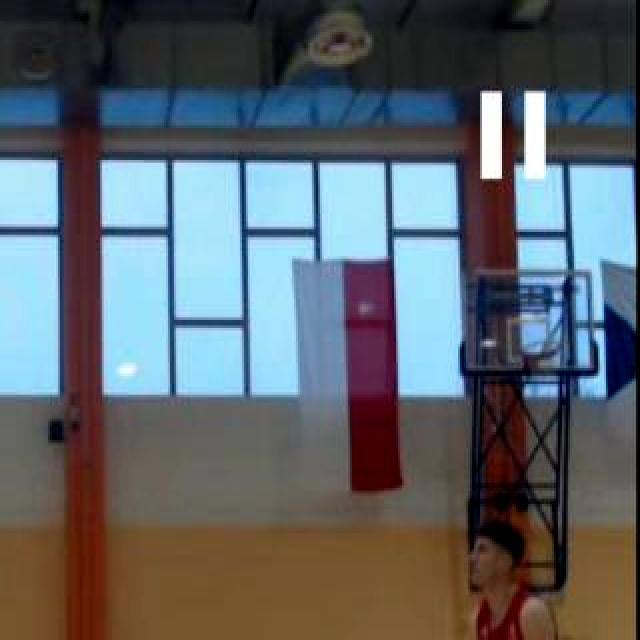

In [ ]:
yolo_test_dataset[0]

### ResNet50 Classification Dataset

This dataset was created using the datasets from above by passing them through a model that is trained on Basketball Hoop and Basketball classes and taken from [Roboflow Universe](https://universe.roboflow.com/roboflow-2dqiu/basketballhoop-qogci/model/3) that was trained using Roboflow 3.0 Object Detection (Fast) model type.

The model takes an image and detects a basket, providing bounding box coordinates. Using these coordinates, I crop the image and resize it to 128x128. After that, I manually select baskets that contain a basketball inside, dividing them into **goal** and **no goal**

It was done to simplify creating a dataset for binary classification. This model won't be used for the goal highlights creation. Instead, I will train a YOLOv5 model to detect the basket.

The created dataset contains two folders representing two classes: **goal** and **no goal**

* Goal contains 1294 images
* No goal contains 6219 images
* Image size: 128x128



#### Download

In [ ]:
!wget "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EVd1a2q0NI5CnB2hRylkAhsBTMgaIYdT6QKn5aJExRMheQ?e=mxSePz&download=1"
!unzip -q "/content/EVd1a2q0NI5CnB2hRylkAhsBTMgaIYdT6QKn5aJExRMheQ?e=mxSePz&download=1"
!rm "/content/EVd1a2q0NI5CnB2hRylkAhsBTMgaIYdT6QKn5aJExRMheQ?e=mxSePz&download=1"

--2024-04-02 15:24:13--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EVd1a2q0NI5CnB2hRylkAhsBTMgaIYdT6QKn5aJExRMheQ?e=mxSePz&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/datasets/resnet_classification.zip?ga=1 [following]
--2024-04-02 15:24:13--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/datasets/resnet_classification.zip?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request 

#### Load data

In [ ]:
resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize( # Normilize images to be in [-1, 1] instead of [0, 256]
        mean=[0.5, 0.5, 0.5], # Standard basic values
        std=[0.5, 0.5, 0.5],
    ),
    transforms.Resize([128, 128])
])

In [ ]:
resnet_dataset = torch_datasets.ImageFolder("resnet_classification", resnet_transform)

split_sizes = [0.7, 0.15, 0.15]
num_workers = os.cpu_count()
train_batch_size = 64
test_batch_size = 128

resnet_train_set, resnet_valid_set, resnet_test_set = torch.utils.data.random_split(resnet_dataset, split_sizes)

resnet_dataset_train = torch.utils.data.DataLoader(resnet_train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
resnet_dataset_valid = torch.utils.data.DataLoader(resnet_valid_set, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)
resnet_dataset_test = torch.utils.data.DataLoader(resnet_test_set, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

#### Details

In [ ]:
resnet_dataset.classes

['goal', 'no goal']

In [ ]:
print("Goal count:", resnet_dataset.targets.count(0))
print("No goal count:", resnet_dataset.targets.count(1))

Goal count: 1294
No goal count: 6219


Portions of goal and no goal images are 17% and 83% respectively

Get a sample image



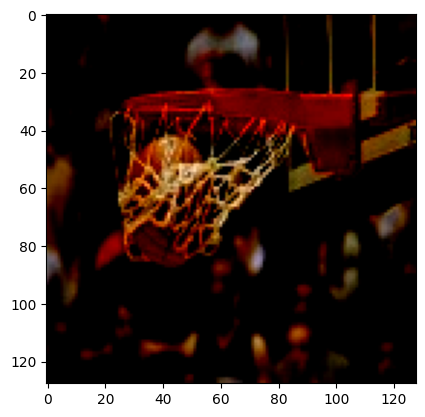

In [ ]:
sample_image, _ = resnet_dataset[100]
grid = torchvision.utils.make_grid([sample_image])
np_grid = grid.permute(1, 2, 0).numpy()
plt.imshow(np_grid)
plt.show()

It looks dark because we applied the transformation above. Let's denormilize it

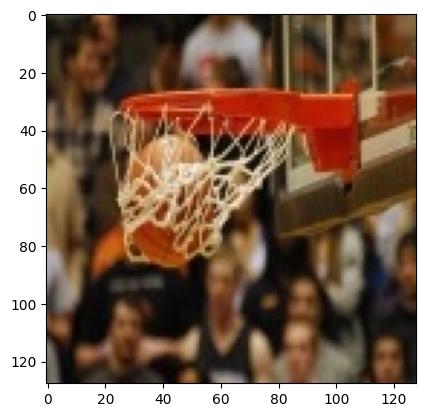

In [ ]:
denormilized_sample_img = sample_image / 2 + 0.5
denormilized_sample_img = denormilized_sample_img.numpy()
plt.imshow(np.transpose(denormilized_sample_img, (1, 2, 0)))
plt.show()

## ResNet50 Goal/No Goal Classification

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

ResNet50 is a popular choice due to its deep architecture with skip connections, which enables effective training of very deep neural networks by mitigating the vanishing gradient problem.

We will explore both not fine-tuned and fine-tuned models and see how they perform with goal classification

Fine-tuned model can be theoretically better due to better generalization. Having previously explored some images and then trained on our dataset, the model can be better at classification task without getting too much attached to the patterns of the basketball hoop.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Not Pretrained

In [ ]:
resnet50_model = torchvision.models.resnet50(weights=None)
resnet50_model = resnet50_model.to(device) # move the model to the current device gpu or cpu

#### Model info

In [ ]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Change last layer (IMPORTANT)

We need to change the last layer in order to customize the model to become a binary classifier. We will make the last layer as a Linear layer with 1 output and add a sigmoid function so we don't need to use `torch.sigmoid` every time

In [ ]:
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(
  nn.Linear(num_ftrs, 1),
  nn.Sigmoid()
)

#### Model summary

In [ ]:
from torchsummary import summary

summary(resnet50_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

#### Test Inference

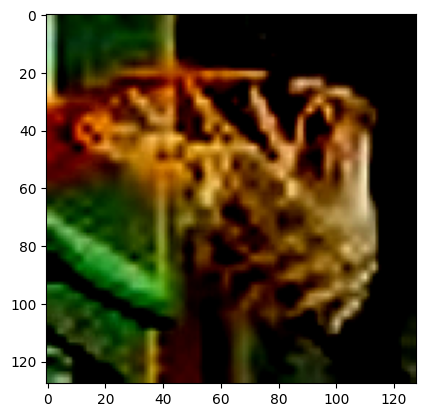

In [ ]:
test_img, _ = resnet_dataset[0]
test_img_plot = test_img.permute(1, 2, 0)
plt.imshow(test_img_plot)
plt.show()

In [ ]:
resnet50_model = resnet50_model.eval()

with torch.no_grad():
    outputs = resnet50_model(test_img.unsqueeze(0))

outputs.item()

0.8474734425544739

#### Train

In [ ]:
epochs = 50
lr = 0.001
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=lr)
loss_func = nn.BCELoss() # Better for binary classifications

experiment = Experiment(
    api_key="<API_KEY>",
    project_name="nure-thesis"
)
experiment.set_name("resnet50_not_pretrained")

early_stopper = EarlyStopper(5, 0, save_path="/content/last_resnet50.pt")
save_best = SaveBestModel(save_path="/content/best_resnet50.pt")

resnet50_history = train(
    resnet50_model,
    epochs=epochs,
    train_loader=resnet_dataset_train,
    val_loader=resnet_dataset_valid,
    device=device,
    optimizer=optimizer,
    criterion=loss_func,
    verbose=True,
    comet_experiment=experiment,
    early_stopping=early_stopper,
    save_best=save_best,
)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/askador/nure-thesis/418ea31e4d344448bb2ced3c15a91d9e




Best validation loss: 0.3161947126363957
Best validation accuracy: 95.29724933451641
Saving best model to '/content/best_resnet50.pt'

Epoch: 0 | Train Loss: 0.0510 Accuracy: 98.21 | Validation Loss: 0.3162 Accuracy: 95.30 | Epoch time (s): -23.2015
Epoch: 1 | Train Loss: 0.0455 Accuracy: 98.21 | Validation Loss: 0.2831 Accuracy: 93.88 | Epoch time (s): -21.9734
Epoch: 2 | Train Loss: 0.0410 Accuracy: 98.52 | Validation Loss: 0.2409 Accuracy: 94.50 | Epoch time (s): -22.7458
Epoch: 3 | Train Loss: 0.0462 Accuracy: 98.27 | Validation Loss: 0.3842 Accuracy: 94.14 | Epoch time (s): -22.2823
Epoch: 4 | Train Loss: 0.0474 Accuracy: 98.29 | Validation Loss: 0.1973 Accuracy: 94.76 | Epoch time (s): -21.2932
Epoch: 5 | Train Loss: 0.0240 Accuracy: 99.13 | Validation Loss: 0.2660 Accuracy: 93.97 | Epoch time (s): -20.9127
Epoch: 6 | Train Loss: 0.0484 Accuracy: 98.54 | Validation Loss: 0.4071 Accuracy: 94.32 | Epoch time (s): -20.7457
Epoch: 7 | Train Loss: 0.0296 Accuracy: 99.01 | Validation 

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/askador/nure-thesis/418ea31e4d344448bb2ced3c15a91d9e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [83]       : (0.0010307292686775327, 0.2031974494457245)
COMET INFO:     train_acc [10]  : (98.212927756654, 99.1444866920152)
COMET INFO:     train_loss [10] : (0.02395372210998272, 0.05100453158649315)
COMET INFO:     val_acc [10]    : (93.5226264418811, 95.29724933451641)
COMET INFO:     val_loss [10]   : (0.19732526877189274, 0.5433106754494116)
COMET INFO:   Others:
COMET INFO:     Name : resnet50_not_pretrained
COMET INFO:   Uploads:
COMET INFO:  

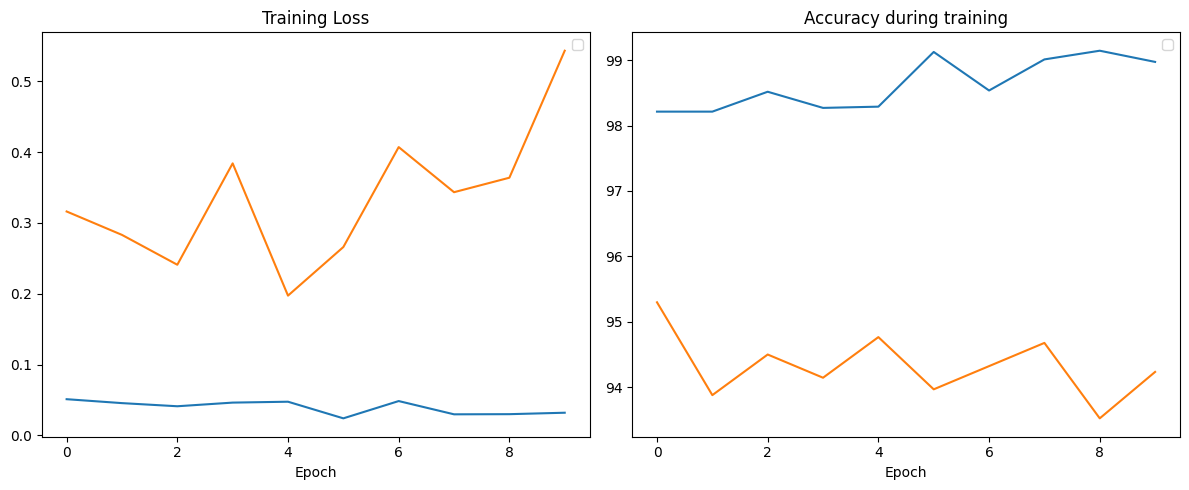

In [ ]:
plot_history(resnet50_history)

As we can see the model starts with validation accuracy 95% right away. In this case it is a decent result althought out dataset only has 17% of goal pictures. But we can do better

Also Validation Loss is greater than Training Loss which indicates overfitting. It can be because the ResNet50 model is just simply too much for this task

#### Load trained model

In [ ]:
!wget -O "/content/best_resnet50.pt" "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EfByRCnF5WFPvJXiew4poO4BhHceM8sLy2ov0990ndaVBw?e=t4LruD&download=1"

resnet50_model.load_state_dict(torch.load("/content/best_resnet50.pt", map_location=device))

--2024-04-01 20:21:34--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EfByRCnF5WFPvJXiew4poO4BhHceM8sLy2ov0990ndaVBw?e=t4LruD&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/best_resnet50.pt?ga=1 [following]
--2024-04-01 20:21:35--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/best_resnet50.pt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awaiting respons

<All keys matched successfully>

#### Inferencing

In [ ]:
resnet50_inferencing = evaluate(resnet50_model, resnet_dataset_test, device=device)

In [ ]:
goal_idx = []
for idx, (image, label) in enumerate(resnet_test_set):
  if label == 0:
    goal_idx.append(idx)

Image Id: 753
Confidence: [0.071] Predict: [0], Original value: [0]


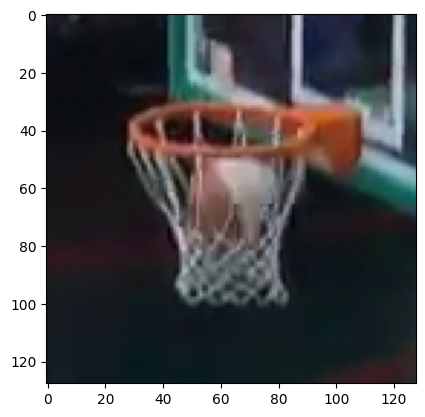

In [ ]:
sample_id = random.choice(goal_idx)
print("Image Id:", sample_id)

img_to_show, _ = resnet_test_set[sample_id]
confidence_value = resnet50_inferencing['confidence'][sample_id]
pred_value = resnet50_inferencing['predictions'][sample_id]
true_value = resnet50_inferencing['actual'][sample_id]
print(f"Confidence: [{confidence_value:.3f}] Predict: [{pred_value}], Actual value: [{true_value}]")
imgshow_tensor(img_to_show)

#### Evaluation

We will calculate F1 score and accuracy score (micro-F1)  using sklearn.metrics

F1 score (also known as F-measure, or balanced F-score) is an error metric which measures model performance by calculating the harmonic mean of precision and recall for the minority positive class.

We will use a weighted average because we have an imbalanced dataset with more examples of No Goal in the dataset.


In [ ]:
resnet50_f1 = f1_score(resnet50_inferencing['actual'], resnet50_inferencing['predictions'], average='weighted')
resnet50_acc_score = accuracy_score(resnet50_inferencing['actual'], resnet50_inferencing['predictions'])
print(f"Resnet50\tF1 Score: {resnet50_f1:.4f} - Accuracy: {resnet50_acc_score:.4f}\n")

Resnet50	F1 Score: 0.9769 - Accuracy: 0.9769



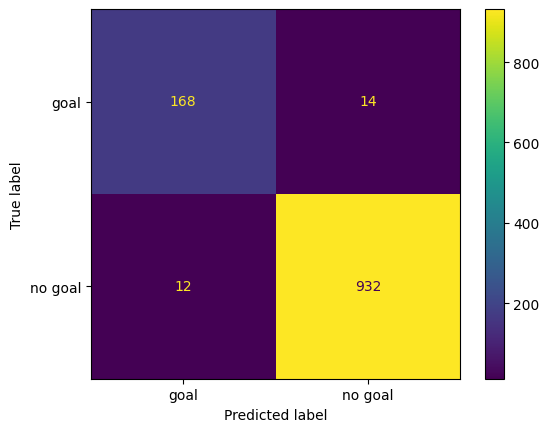

In [ ]:
resnet50_cm = confusion_matrix(resnet50_inferencing['actual'], resnet50_inferencing['predictions'])
cmdisp = ConfusionMatrixDisplay(confusion_matrix=resnet50_cm, display_labels=['goal', 'no goal'])
cmdisp.plot()

The confusion matrix demonstrates that the model guessed 15.2% of goal images out of 17% that are in our dataset. But we can do better

Overall not fine-tuned ResNet50 has a weighted **F1 Score: 0.9769** and **Accuracy: 0.9769**

### Pretrained

In [ ]:
resnet50_finetuned_model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50_finetuned_model = resnet50_finetuned_model.to(device) # move the model to the current device gpu or cpu

In [ ]:
num_ftrs = resnet50_finetuned_model.fc.in_features
resnet50_finetuned_model.fc = nn.Sequential(
  nn.Linear(num_ftrs, 1),
  nn.Sigmoid()
)

#### Training

In [ ]:
epochs = 100
lr = 0.0001
optimizer = torch.optim.Adam(resnet50_finetuned_model.parameters(), lr=lr)
loss_func = nn.BCELoss() # Better for binary classifications

experiment = Experiment(
    api_key="<API_KEY>",
    project_name="nure-thesis"
)
experiment.set_name("resnet50_pretrained")

early_stopper = EarlyStopper(6, 0, save_path="/content/last_resnet50_pretrained.pt")
save_best = SaveBestModel(save_path="/content/best_resnet50_pretrained.pt")

resnet50_pretrained_history = train(
    resnet50_finetuned_model,
    epochs=epochs,
    train_loader=resnet_dataset_train,
    val_loader=resnet_dataset_valid,
    device=device,
    optimizer=optimizer,
    criterion=loss_func,
    verbose=True,
    comet_experiment=experiment,
    early_stopping=early_stopper,
    save_best=save_best,
)

experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/askador/nure-thesis/cd93fa2b07b9435ba1e4f593fc7ae1f7
COMET INFO:   Others:
COMET INFO:     Name : resnet50_pretrained
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET 

Epoch: 0 | Train Loss: 0.2866 Accuracy: 90.53 | Validation Loss: 0.1218 Accuracy: 95.83 | Epoch time (s): -21.9827

Best validation loss: 0.12178508047520216
Best validation accuracy: 95.82963620230701
Saving best model to '/content/best_resnet50_pretrained.pt'

Epoch: 1 | Train Loss: 0.0995 Accuracy: 96.52 | Validation Loss: 0.0986 Accuracy: 96.81 | Epoch time (s): -20.5875

Best validation loss: 0.09862956764323583
Best validation accuracy: 96.80567879325643
Saving best model to '/content/best_resnet50_pretrained.pt'

Epoch: 2 | Train Loss: 0.0614 Accuracy: 97.83 | Validation Loss: 0.1024 Accuracy: 96.98 | Epoch time (s): -21.2752
Epoch: 3 | Train Loss: 0.0354 Accuracy: 98.84 | Validation Loss: 0.1004 Accuracy: 96.98 | Epoch time (s): -21.0989
Epoch: 4 | Train Loss: 0.0273 Accuracy: 99.11 | Validation Loss: 0.1246 Accuracy: 95.92 | Epoch time (s): -20.3701
Epoch: 5 | Train Loss: 0.0172 Accuracy: 99.37 | Validation Loss: 0.1071 Accuracy: 96.98 | Epoch time (s): -20.7254
Epoch: 6 | Tra

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/askador/nure-thesis/caedac75fb6343c988803c29aa2cabf2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [67]      : (0.0013590657617896795, 0.6800329685211182)
COMET INFO:     train_acc [8]  : (90.53231939163499, 99.52471482889734)
COMET INFO:     train_loss [8] : (0.01641233483260363, 0.28664280763143823)
COMET INFO:     val_acc [8]    : (95.82963620230701, 97.24933451641526)
COMET INFO:     val_loss [8]   : (0.09862956764323583, 0.13090623424660344)
COMET INFO:   Others:
COMET INFO:     Name : resnet50_pretrained
COMET INFO:   Uploads:
COMET INFO:     e

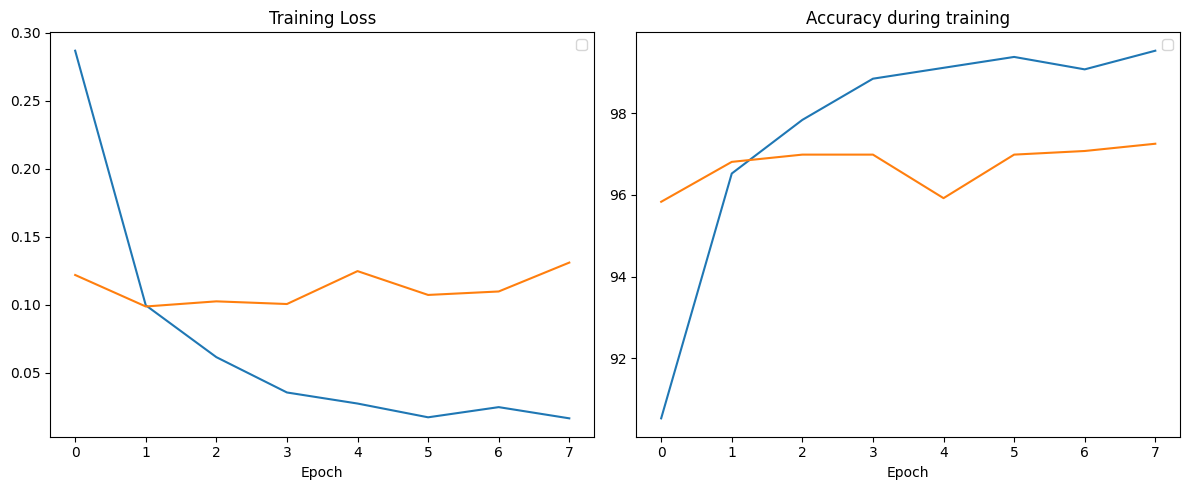

In [ ]:
plot_history(resnet50_pretrained_history)

Fine-tuned ResNet50 performs better with our task. Validation accuracy is 97.25 which shows that the model is ready to be used in our task to create highlights as long as we tolerate some minor errors.

Validation Loss got greater than training loss which indicates underfitting. It indicates that further training is needed to reduce the loss or get more data to train on.

#### Load trained model

In [ ]:
!wget -O "/content/last_resnet50_pretrained.pt" "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EXmsIi_yOspGlHysZXDJf_4BuumShTHBcgl59iYCWR2SmA?e=4u4d1k&download=1"

resnet50_finetuned_model.load_state_dict(torch.load("/content/last_resnet50_pretrained.pt", map_location=device))

--2024-04-01 20:23:07--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EXmsIi_yOspGlHysZXDJf_4BuumShTHBcgl59iYCWR2SmA?e=4u4d1k&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/last_resnet50_pretrained.pt?ga=1 [following]
--2024-04-01 20:23:08--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/last_resnet50_pretrained.pt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request 

<All keys matched successfully>

#### Inferencing

In [ ]:
resnet50_pretrained_inferencing = evaluate(resnet50_finetuned_model, resnet_dataset_test, device=device)

Image Id: 180
Confidence: [0.000] Predict: [0], Original value: [0]


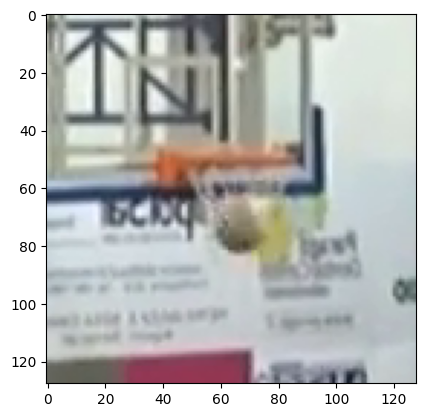

In [ ]:
sample_id = random.choice(goal_idx)
print("Image Id:", sample_id)

img_to_show, _ = resnet_test_set[sample_id]
confidence_value = resnet50_pretrained_inferencing['confidence'][sample_id]
pred_value = resnet50_pretrained_inferencing['predictions'][sample_id]
true_value = resnet50_pretrained_inferencing['actual'][sample_id]
print(f"Confidence: [{confidence_value:.3f}] Predict: [{pred_value}], Actual value: [{true_value}]")
imgshow_tensor(img_to_show)

#### Evaluation

In [ ]:
resnet50_pretrained_f1 = f1_score(resnet50_pretrained_inferencing['actual'], resnet50_pretrained_inferencing['predictions'], average='weighted')
resnet50_pretrained_acc_score = accuracy_score(resnet50_pretrained_inferencing['actual'], resnet50_pretrained_inferencing['predictions'])
print(f"Resnet50\tF1 Score: {resnet50_pretrained_f1:.4f} - Accuracy: {resnet50_pretrained_acc_score:.4f}\n")

Resnet50	F1 Score: 0.9956 - Accuracy: 0.9956



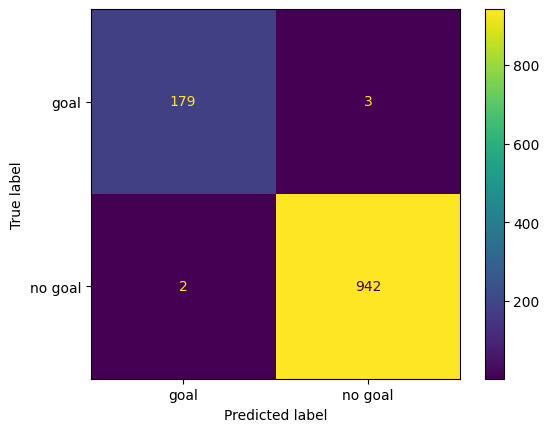

In [ ]:
resnet50_pretrained_cm = confusion_matrix(resnet50_pretrained_inferencing['actual'], resnet50_pretrained_inferencing['predictions'])
cmdisp = ConfusionMatrixDisplay(confusion_matrix=resnet50_pretrained_cm, display_labels=['goal', 'no goal'])
cmdisp.plot()

The confusion matrix shows proves that that the fine-tuned model is better. The model guessed 16% of goal images out of 17% that are in our dataset.

Fine-tuned ResNet50 has a weighted **F1 Score: 0.9956** and **Accuracy: 0.9956**

### Conclusions on ResNet50

We already theoretically concluded that fine-tuned model could perform better than simply trained from scratch, and our training has proved us right.

The not fine-tuned ResNet50 performs with accuracy of 95% and F1 Score of 0.9769.

While the fine-tuned ResNet50 performs with 97.2% accuracy and F1 Score of 0.9956.

We will use the fine-tuned version for our highlights generation

## YOLOv5 Basket Detection

YOLOv5 is a model in the You Only Look Once (YOLO) family of computer vision models. YOLOv5 is a popular object detection model known for its speed and accuracy and it uses a convolutional neural network (CNN) to predict the bounding boxes and class probabilities of objects in input images

The YOLO algorithm divides the input image into a grid of cells, and for each cell, it predicts the probability of the presence of an object and the bounding box coordinates of the object. It also predicts the class of the object. Unlike two-stage object detectors such as R-CNN and its variants, YOLO processes the entire image in one pass, making it faster and more efficient.

YOLOv5 has a variety of models, nano, small, medium, large, xlarge, but for this project purposes I decided to use the nano version. The decision has two reasons:
1. I simply don't have a GPU and with my CPU it would take an eternity to train so I need to use Colaboratory, but it has its T4 GPU limits;
2. The basket detection is a simple task, so I consider the nano model to perform well

### Clone YOLOv5 repo

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 16522, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 16522 (delta 50), reused 52 (delta 16), pack-reused 16402
Receiving objects: 100% (16522/16522), 15.12 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (11312/11312), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.7/744.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 916.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 

### Train

In [ ]:
comet_ml.init(
    api_key="<API_KEY>",
    project_name="nure_thesis"
)

COMET INFO: Valid Comet API Key saved in /content/drive/MyDrive/.comet.config (set COMET_CONFIG to change where it is saved).


In [ ]:
!python /content/yolov5/train.py --img 640 --batch-size 32 --epochs 50 --project '/content/basket-detection/' --data "/content/yolov5-basket-dataset/data.yaml" --weights yolov5n.pt --cache

2024-04-01 15:48:57.804007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 15:48:57.804061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 15:48:57.805525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=, data=/content/yolov5-basket-dataset/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=

The model was training almost 3 and a half hours and the value of mAP50 0.944 which is not that great but the value of mAP50-95 is 0.744 meaning the model can perform well enough

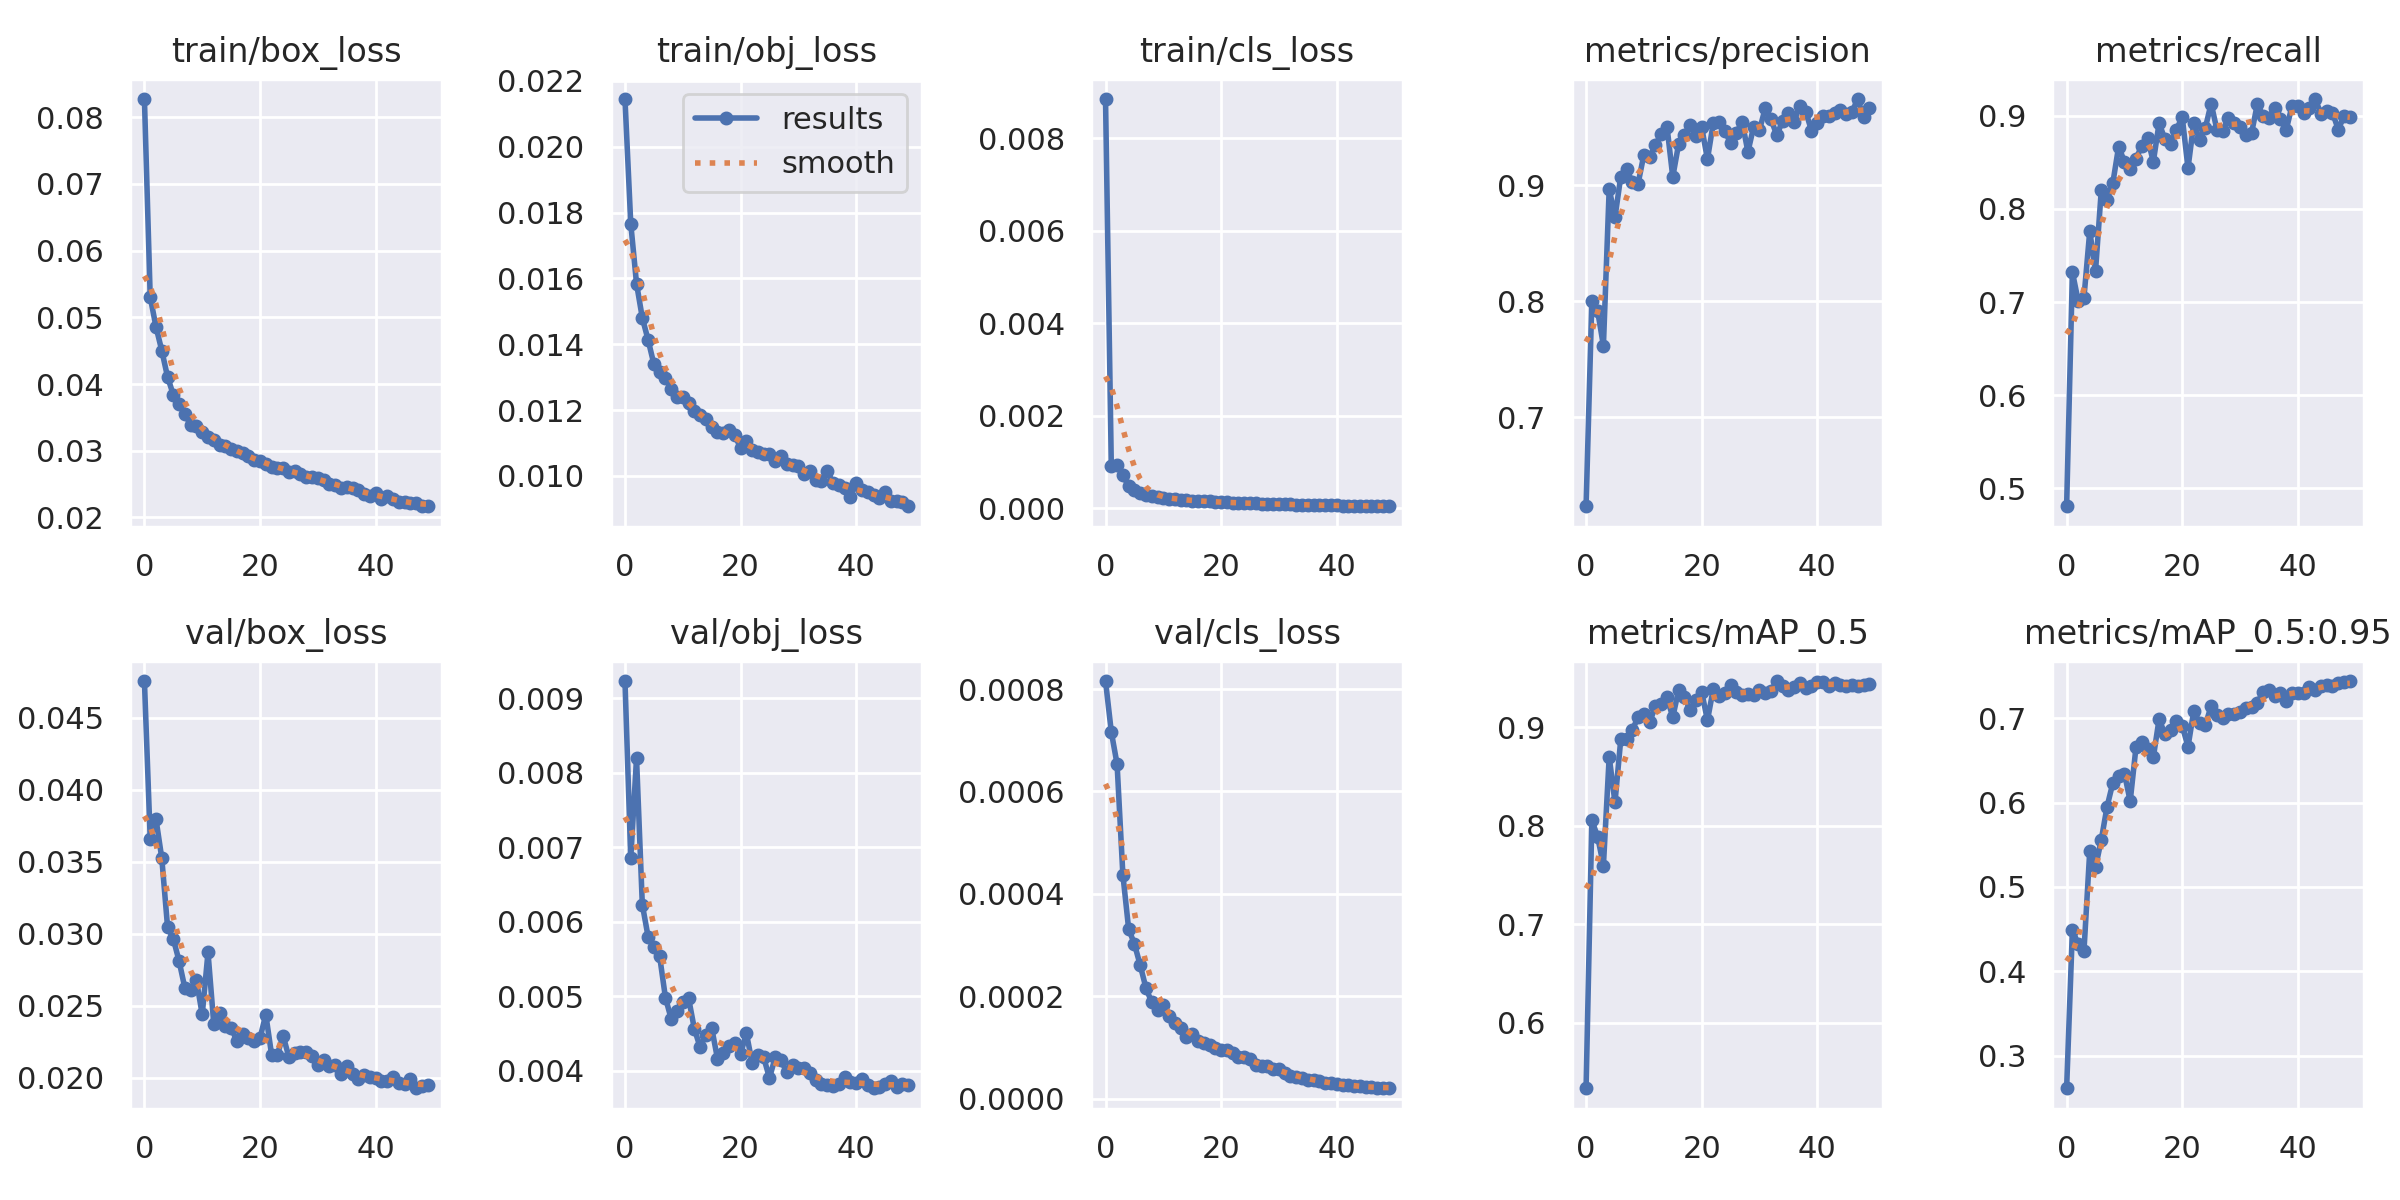

In [ ]:
yolo_train_results = Image.open('/content/basket-detection/results.png')
yolo_train_results

### Load trained model

In [ ]:
!wget -O "yolov5_basket.pt" "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EfEr05T1epVMtAF6-5Qy56oBEYzbd3pffAbJZydpohVxoQ?e=ewzHid&download=1"

--2024-04-02 15:27:41--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EfEr05T1epVMtAF6-5Qy56oBEYzbd3pffAbJZydpohVxoQ?e=ewzHid&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/yolov5_basket.pt?ga=1 [following]
--2024-04-02 15:27:42--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/yolov5_basket.pt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awaiting respons

In [ ]:
yolov5_basket = torch.hub.load("ultralytics/yolov5", 'custom', path="/content/yolov5_basket.pt", force_reload=False, device=device)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-4-2 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


### Inference

array([[[132, 157, 214],
        [132, 157, 214],
        [131, 156, 213],
        ...,
        [ 84, 116, 193],
        [ 84, 116, 193],
        [ 84, 116, 193]],

       [[133, 158, 215],
        [132, 157, 214],
        [131, 156, 213],
        ...,
        [ 84, 116, 193],
        [ 84, 116, 193],
        [ 84, 116, 193]],

       [[132, 158, 217],
        [131, 157, 216],
        [130, 156, 215],
        ...,
        [ 84, 116, 193],
        [ 84, 116, 193],
        [ 84, 116, 193]],

       ...,

       [[128,  96,  57],
        [130,  98,  59],
        [178, 146, 105],
        ...,
        [ 24,  10,   0],
        [ 31,  17,   4],
        [ 36,  23,   7]],

       [[112,  78,  41],
        [116,  82,  44],
        [170, 137,  96],
        ...,
        [ 21,   7,   0],
        [ 28,  16,   2],
        [ 33,  21,   7]],

       [[116,  82,  45],
        [119,  85,  47],
        [175, 141, 103],
        ...,
        [ 18,   4,   0],
        [ 26,  14,   0],
        [ 32,  20,   6]]], dtype=uint8)
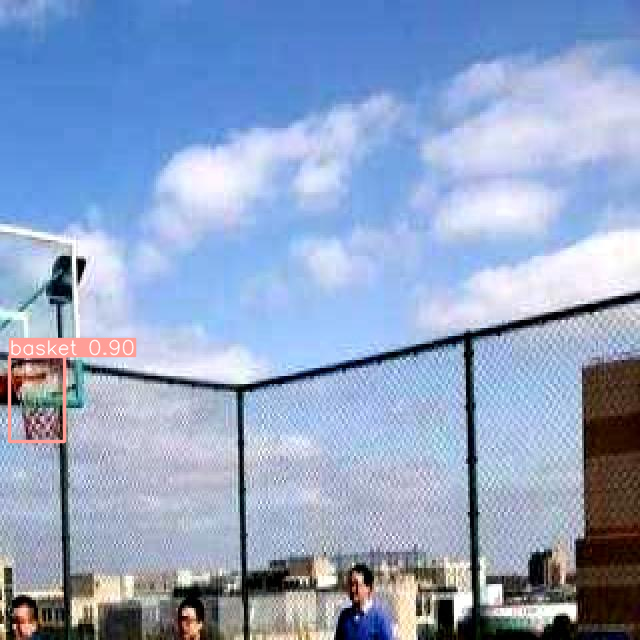

In [ ]:
sample_id = 16
yolo_test = yolo_test_dataset[sample_id]
yolo_test

In [ ]:
yolo_result = yolov5_basket(yolo_test)
yolo_result

WARNING ⚠️ NMS time limit 0.550s exceeded


YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 640x640 1 basket
Speed: 3.7ms pre-process, 45.9ms inference, 801.9ms NMS per image at shape (1, 3, 640, 640)

In [ ]:
yolo_result.pandas().xyxy[0]

xmin        ymin       xmax        ymax  confidence  class    name
0  9.070948  356.306885  64.002708  441.595703    0.899249      1  basket

In [ ]:
len(yolo_result.xyxy[0])

1

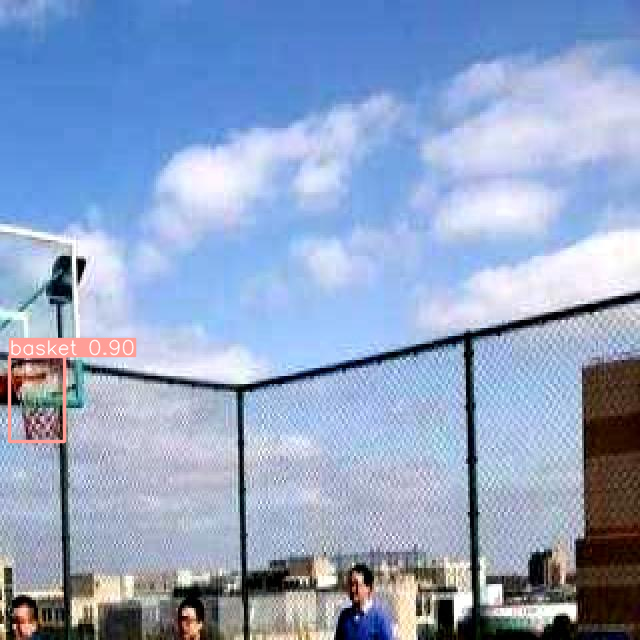

In [ ]:
yolo_result.show()

array([[[177, 183, 209],
        [181, 187, 211],
        [188, 194, 218],
        ...,
        [255, 163, 157],
        [255, 159, 153],
        [255, 157, 151]],

       [[177, 184, 210],
        [182, 190, 213],
        [189, 197, 220],
        ...,
        [255, 157, 151],
        [255, 157, 151],
        [255, 159, 153]],

       [[ 70,  80, 105],
        [ 77,  88, 110],
        [ 87,  98, 118],
        ...,
        [255, 175, 170],
        [255, 230, 229],
        [255, 173, 168]],

       ...,

       [[167, 203, 239],
        [147, 183, 219],
        [146, 182, 216],
        ...,
        [126, 136, 135],
        [128, 138, 139],
        [136, 146, 148]],

       [[145, 181, 217],
        [168, 204, 240],
        [166, 202, 238],
        ...,
        [117, 127, 126],
        [121, 131, 132],
        [142, 152, 154]],

       [[120, 158, 195],
        [189, 227, 255],
        [189, 227, 255],
        ...,
        [114, 124, 125],
        [118, 128, 129],
        [149, 159, 161]]], dtype=uint8)
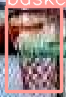

In [ ]:
cropped_yolo_result = yolo_result.crop(save=False)
cv2.cvtColor(cropped_yolo_result[0].get('im'), cv2.COLOR_BGR2RGB)

#### Kitty test

In [ ]:
!wget "https://cdn.britannica.com/34/235834-050-C5843610/two-different-breeds-of-cats-side-by-side-outdoors-in-the-garden.jpg"

--2024-04-02 15:28:02--  https://cdn.britannica.com/34/235834-050-C5843610/two-different-breeds-of-cats-side-by-side-outdoors-in-the-garden.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 108.138.94.29, 108.138.94.97, 108.138.94.126, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|108.138.94.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240851 (235K) [image/jpeg]
Saving to: ‘two-different-breeds-of-cats-side-by-side-outdoors-in-the-garden.jpg’

two-different-breed 100%[===================>] 235.21K  --.-KB/s    in 0.02s   

2024-04-02 15:28:02 (10.1 MB/s) - ‘two-different-breeds-of-cats-side-by-side-outdoors-in-the-garden.jpg’ saved [240851/240851]



In [ ]:
cat_img = cv2.imread("/content/two-different-breeds-of-cats-side-by-side-outdoors-in-the-garden.jpg", cv2.IMREAD_ANYCOLOR)
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)

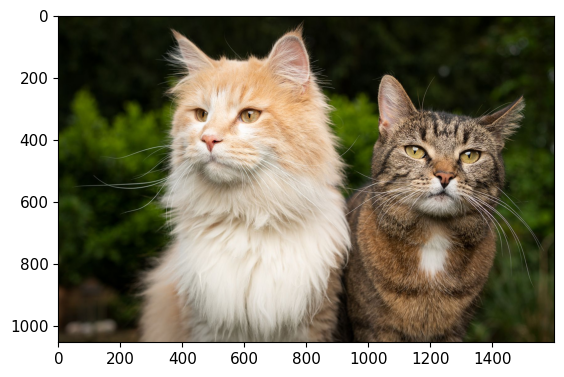

In [ ]:
%matplotlib inline
plt.imshow(cat_img)
plt.show()

In [ ]:
yolo_cat_result = yolov5_basket(cat_img)
yolo_cat_result

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1054x1600 (no detections)
Speed: 20.7ms pre-process, 150.9ms inference, 63.2ms NMS per image at shape (1, 3, 448, 640)

In [ ]:
yolo_cat_result.xyxy

[tensor([], device='cuda:0', size=(0, 6))]

In [ ]:
len(yolo_cat_result.xyxy[0])

0

## YOLOv5 + ResNet50

### Load trained models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### ResNet50

In [ ]:
resnet50 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50 = resnet50.to(device)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
  nn.Linear(num_ftrs, 1),
  nn.Sigmoid()
)

In [ ]:
!wget -O "/content/last_resnet50_pretrained.pt" "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EXmsIi_yOspGlHysZXDJf_4BuumShTHBcgl59iYCWR2SmA?e=4u4d1k&download=1"

resnet50.load_state_dict(torch.load("/content/last_resnet50_pretrained.pt", map_location=device))
resnet50 = resnet50.to(device)
resnet50 = resnet50.eval()

--2024-04-02 16:25:23--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EXmsIi_yOspGlHysZXDJf_4BuumShTHBcgl59iYCWR2SmA?e=4u4d1k&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/last_resnet50_pretrained.pt?ga=1 [following]
--2024-04-02 16:25:24--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/last_resnet50_pretrained.pt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request 

#### YOLOv5

In [ ]:
!wget -O "yolov5_basket.pt" "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EfEr05T1epVMtAF6-5Qy56oBEYzbd3pffAbJZydpohVxoQ?e=ewzHid&download=1"

yolov5 = torch.hub.load("ultralytics/yolov5", 'custom', path="/content/yolov5_basket.pt", force_reload=False, device=device)

--2024-04-02 15:37:16--  https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/EfEr05T1epVMtAF6-5Qy56oBEYzbd3pffAbJZydpohVxoQ?e=ewzHid&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/yolov5_basket.pt?ga=1 [following]
--2024-04-02 15:37:17--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/models/yolov5_basket.pt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awaiting respons

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-2 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


### Inference


Test on a single frame 1280x720 with a baskteball in the basket

In [ ]:
!wget -O "test_goal.png" "https://ktureedu-my.sharepoint.com/:i:/g/personal/serhii_fedosov_nure_ua/ETx3V8UX4qVDr5Ch22RkR4sBkyzPu-2czylGl3n5J5REAQ?e=scRrri&download=1"

--2024-04-02 16:30:28--  https://ktureedu-my.sharepoint.com/:i:/g/personal/serhii_fedosov_nure_ua/ETx3V8UX4qVDr5Ch22RkR4sBkyzPu-2czylGl3n5J5REAQ?e=scRrri&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/images/test_goal.png?ga=1 [following]
--2024-04-02 16:30:28--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/images/test_goal.png?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awaiting response... 2

In [ ]:
!wget -O "test_nba_goal.png" "https://ktureedu-my.sharepoint.com/:i:/g/personal/serhii_fedosov_nure_ua/EflzmJiMTyJApbY9z60pyMcBOjctEs0SvBi0hLVBCq9-Mg?e=pT6UYh&download=1"

--2024-04-02 15:37:40--  https://ktureedu-my.sharepoint.com/:i:/g/personal/serhii_fedosov_nure_ua/EflzmJiMTyJApbY9z60pyMcBOjctEs0SvBi0hLVBCq9-Mg?e=pT6UYh&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/images/test_1280x720_goal.png?ga=1 [following]
--2024-04-02 15:37:41--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/images/test_1280x720_goal.png?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awai

In [ ]:
test_nba_goal = cv2.imread("/content/test_nba_goal.png", cv2.IMREAD_ANYCOLOR)

In [ ]:
test_goal = cv2.imread("/content/test_goal.png", cv2.IMREAD_ANYCOLOR)

In [ ]:
yolo_test_result = yolov5(test_goal)
yolo_test_result

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 720x1280 (no detections)
Speed: 10.4ms pre-process, 15.7ms inference, 0.8ms NMS per image at shape (1, 3, 384, 640)

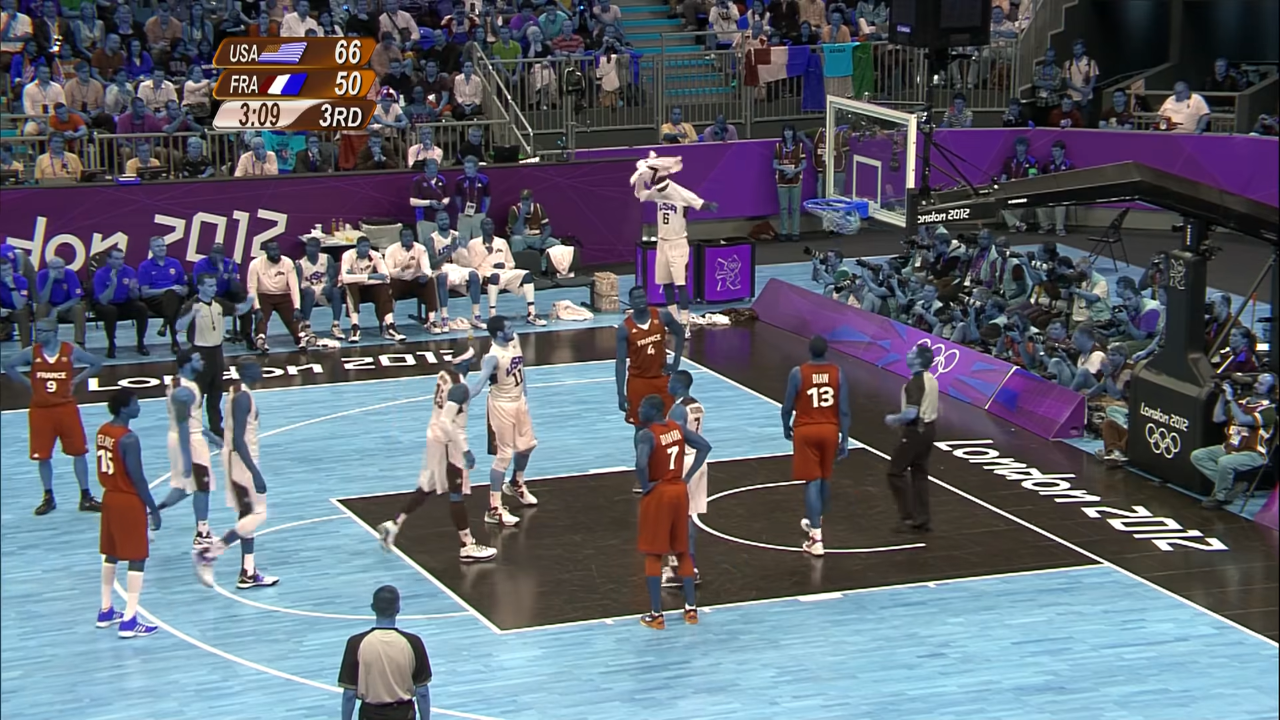

In [ ]:
yolo_test_result.show()

In [ ]:
test_goal = cv2.cvtColor(test_goal, cv2.COLOR_BGR2RGB)

In [ ]:
yolo_test_result = yolov5(test_goal)
yolo_test_result

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 720x1280 1 basket
Speed: 7.9ms pre-process, 14.9ms inference, 2.4ms NMS per image at shape (1, 3, 384, 640)

In this case we can't just rely on the `crop()` method that torch provides us because the bounding box is not covering the basket fully.

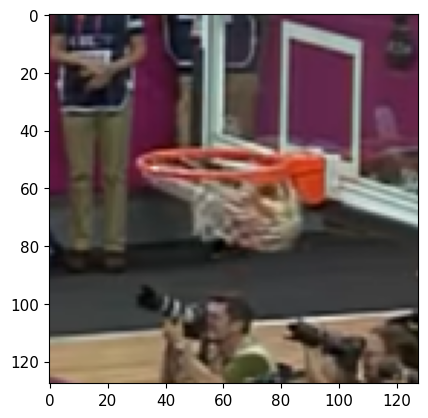

In [ ]:
if len(yolo_test_result.xyxy[0]) != 0:
  x, y = get_basket_center(yolo_test_result)
  if x != None:
    cropped_image = test_goal[y-64:y+64, x-64:x+64] # we want a 128x128 image, so we go from -64 to 64
    plt.imshow(cropped_image)
    plt.show()

In [ ]:
os.makedirs("/content/crops", exist_ok=True)
cv2.imwrite("/content/crops/test_goal_crop.png", cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

True

In [ ]:
resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    transforms.Resize([128, 128])
])

In [ ]:
cropped_image_tensor = resnet_transform(cropped_image).to(device)

In [ ]:
resnet_test_nba_result = resnet50(cropped_image_tensor)

ValueError: expected 4D input (got 3D input)

In [ ]:
cropped_image_tensor.shape

torch.Size([3, 128, 128])

Since ResNet50 was trained on batched images, we need to add one more dimension

In [ ]:
cropped_image_tensor = cropped_image_tensor[None, :]
cropped_image_tensor = cropped_image_tensor.to(device)

In [ ]:
cropped_image_tensor.shape

torch.Size([1, 3, 128, 128])

In [ ]:
resnet_test_nba_result = resnet50(cropped_image_tensor)

In [ ]:
resnet_test_nba_result.item()

0.016444945707917213

0 - goal \
1 - no goal

The test goal image goes through our YOLOv5 object detection with ResNet50 classification process pretty well

## Goals detection

I chose a basketball game [Ukraine v Poland | FIBA EuroBasket 2022](https://www.youtube.com/watch?v=05Y9a5vRIxI)

Stats of the game: https://www.fiba.basketball/eurobasket/2022/game/1109/Ukraine-Poland#tab=overview

Flashscore with precise stats: https://www.flashscore.in/match/xEuPO4cG/#/match-summary/match-statistics/1

I manually edited the video, setting the resolution to 1280x720 with 25 frames per second. The video length is 15:46 because I took only the first quarter of the game and removed the short in-game highlights. Throughout the first quarter, 22 goals were made.

I also created a small clip 5 seconds long just to test the process

### Small clip test

#### Load small clip

In [ ]:
!wget -O "small_clip.mp4" "https://ktureedu-my.sharepoint.com/:v:/g/personal/serhii_fedosov_nure_ua/ETT6d1a-dBhIp3jcv3ulbGIB4RNkbtIrndchVfBYFD2k6A?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=67Ms94&download=1"

clip_path = "/content/small_clip.mp4"

--2024-04-02 17:12:45--  https://ktureedu-my.sharepoint.com/:v:/g/personal/serhii_fedosov_nure_ua/ETT6d1a-dBhIp3jcv3ulbGIB4RNkbtIrndchVfBYFD2k6A?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=67Ms94&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/videos/small-clip.mp4?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0N

#### Test

In [ ]:
resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    transforms.Resize([128, 128])
])

In [ ]:
small_clip_cap = cv2.VideoCapture(clip_path)

frames_goal_conf = []
frame_count = int(small_clip_cap.get(cv2.CAP_PROP_FRAME_COUNT))

os.makedirs("/content/crops", exist_ok=True)
os.makedirs("/content/crops/test", exist_ok=True)

with torch.no_grad():
  for i in tqdm(range(frame_count)):

    is_read, frame = small_clip_cap.read()

    if not is_read:
      continue

    frame = np.array(frame, dtype=np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    try:
      yolov5_result = yolov5(frame)

      if len(yolov5_result.xyxy[0]) == 0:
        frames_goal_conf.append(1)
        continue

      x, y = get_basket_center(yolov5_result)

      # Crop. I use max(0, y-64) in case the basket center has _x_ or _y_ less than 64
      cropped_frame = frame[max(0, y-64):max(0, y+64), max(0, x-64):max(0, x+64)]
      # Transform
      cropped_frame_tensor = resnet_transform(cropped_frame)
      # Add an additional dimension
      cropped_frame_tensor = cropped_frame_tensor[None, :]
      cropped_frame_tensor = cropped_frame_tensor.to(device)


      cv2.imwrite(f"/content/crops/test/small_clip_{i}.png", cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))

      resnet50_result = resnet50(cropped_frame_tensor)

      frames_goal_conf.append(resnet50_result.item())

    except RuntimeError:
      frames_goal_conf.append(1)

small_clip_cap.release()

100%|██████████| 135/135 [00:03<00:00, 38.67it/s]


In [ ]:
!zip -r "small_clip_crops.zip" "/content/crops/test"

In [ ]:
!rm -rf /content/crops/test/

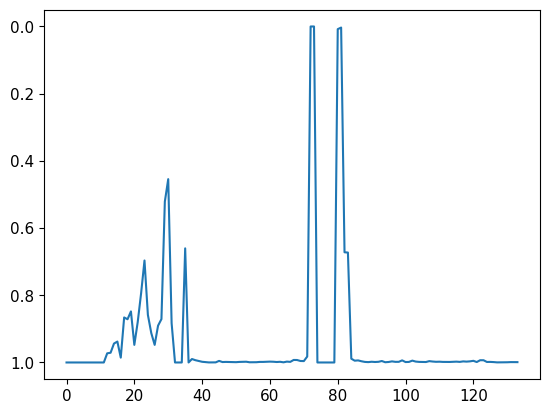

In [ ]:
plt.plot(range(len(frames_goal_conf)), frames_goal_conf)
plt.gca().invert_yaxis() # Inverted axis because 1 - no goal and 0 - goal

plt.show()

Around frames 20 to 40 we see a spike which is reasonable because around these frames there was a shoot attempt, but it was not a goal.

The actual goal was around 70-80 frames. It's weird that it has two different spikes, instead of one big spike. It can be because after the ball appears in the net and leaves it, the net moves and in some frames it can look like it is still meaning no goal

### First quarter of the game (15 minutes)

#### Load the video

In [ ]:
!wget -O "basketball_game.mp4" "https://ktureedu-my.sharepoint.com/:v:/g/personal/serhii_fedosov_nure_ua/EZ4AqsTVlVhCpq4d5Fmj0v4B3bx7CS3HH-HTnMWgqxXcuQ?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=zchSRX&download=1"

game_path = "/content/basketball_game.mp4"

--2024-04-02 18:32:40--  https://ktureedu-my.sharepoint.com/:v:/g/personal/serhii_fedosov_nure_ua/EZ4AqsTVlVhCpq4d5Fmj0v4B3bx7CS3HH-HTnMWgqxXcuQ?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=zchSRX&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/videos/Ukraine%20v%20Poland%20FIBA%20EuroBasket%202022%20Q1.mp4?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZ

#### Finding goal confidence of frames and finding timimings

In [ ]:
resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    transforms.Resize([128, 128])
])

In [ ]:
game_cap = cv2.VideoCapture(game_path)

frames_goal_conf = []
frame_count = int(game_cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = game_cap.get(cv2.CAP_PROP_FPS)

os.makedirs("/content/crops", exist_ok=True)
os.makedirs("/content/crops/game", exist_ok=True)


with torch.no_grad():
  for i in tqdm(range(frame_count)):

    is_read, frame = game_cap.read()

    if not is_read:
      continue

    frame = np.array(frame, dtype=np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    try:
      yolov5_result = yolov5(frame)

      if len(yolov5_result.xyxy[0]) == 0:
        frames_goal_conf.append(1)
        continue

      x, y = get_basket_center(yolov5_result)

      # Crop. I use max(0, y-64) in case the basket center has _x_ or _y_ less than 64
      cropped_frame = frame[max(0, y-64):max(0, y+64), max(0, x-64):max(0, x+64)]
      # Transform
      cropped_frame_tensor = resnet_transform(cropped_frame)
      # Add an additional dimension
      cropped_frame_tensor = cropped_frame_tensor[None, :]
      cropped_frame_tensor = cropped_frame_tensor.to(device)

      cv2.imwrite(f"/content/crops/game/game_{i}.png", cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))

      resnet50_result = resnet50(cropped_frame_tensor)
      frames_goal_conf.append(resnet50_result.item())

    except RuntimeError:
      frames_goal_conf.append(1)

game_cap.release()

100%|██████████| 23674/23674 [08:35<00:00, 45.94it/s]


#### Save inference confidence values

In [ ]:
with open('/content/frames_goal_conf.txt', 'w') as f:
  f.write(json.dumps(frames_goal_conf))

#### Load frame confidence values and actual goal timings

In [ ]:
!wget -O "frames_goal_conf.txt" "https://ktureedu-my.sharepoint.com/:t:/g/personal/serhii_fedosov_nure_ua/EcSC2l7eMZhEqNQRj1BZUIQBXiKnTwGbuITWSWMgo7RfFg?e=b2trZh&download=1"

with open("/content/frames_goal_conf.txt") as f:
  frames_goal_conf = json.load(f)

--2024-04-02 20:52:03--  https://ktureedu-my.sharepoint.com/:t:/g/personal/serhii_fedosov_nure_ua/EcSC2l7eMZhEqNQRj1BZUIQBXiKnTwGbuITWSWMgo7RfFg?e=b2trZh&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/frames_goal_conf.txt?ga=1 [following]
--2024-04-02 20:52:04--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/frames_goal_conf.txt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awaiting response... 2

In [ ]:
!wget -O "actual_goal_timing.txt" "https://ktureedu-my.sharepoint.com/:t:/g/personal/serhii_fedosov_nure_ua/EW7w3BV_Kf9PlliNKUzMUKIBRs3HxeTmxlaCDNa04uvoLA?e=4yx3ce&download=1"


--2024-04-02 20:45:23--  https://ktureedu-my.sharepoint.com/:t:/g/personal/serhii_fedosov_nure_ua/EW7w3BV_Kf9PlliNKUzMUKIBRs3HxeTmxlaCDNa04uvoLA?e=4yx3ce&download=1
Resolving ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ktureedu-my.sharepoint.com (ktureedu-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/actual_goal_timings.txt?ga=1 [following]
--2024-04-02 20:45:25--  https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/actual_goal_timings.txt?ga=1
Reusing existing connection to ktureedu-my.sharepoint.com:443.
HTTP request sent, awaiting respons

The actual_goal_timing.txt file contains timestamps in the format h:m:s. All timestamps are ordered on a single line separated by a space

In [ ]:
with open("/content/actual_goal_timing.txt") as f:
  line = f.readline()
  actual_goal_timings = line.split()

#### Analysis

In [ ]:
fps = 25.0

In [ ]:
frames_with_goal = [conf if conf < 0.5 else 1 for conf in frames_goal_conf]
actual_goal_frames = [int(hms_to_seconds(t) * fps) for t in actual_goal_timings]

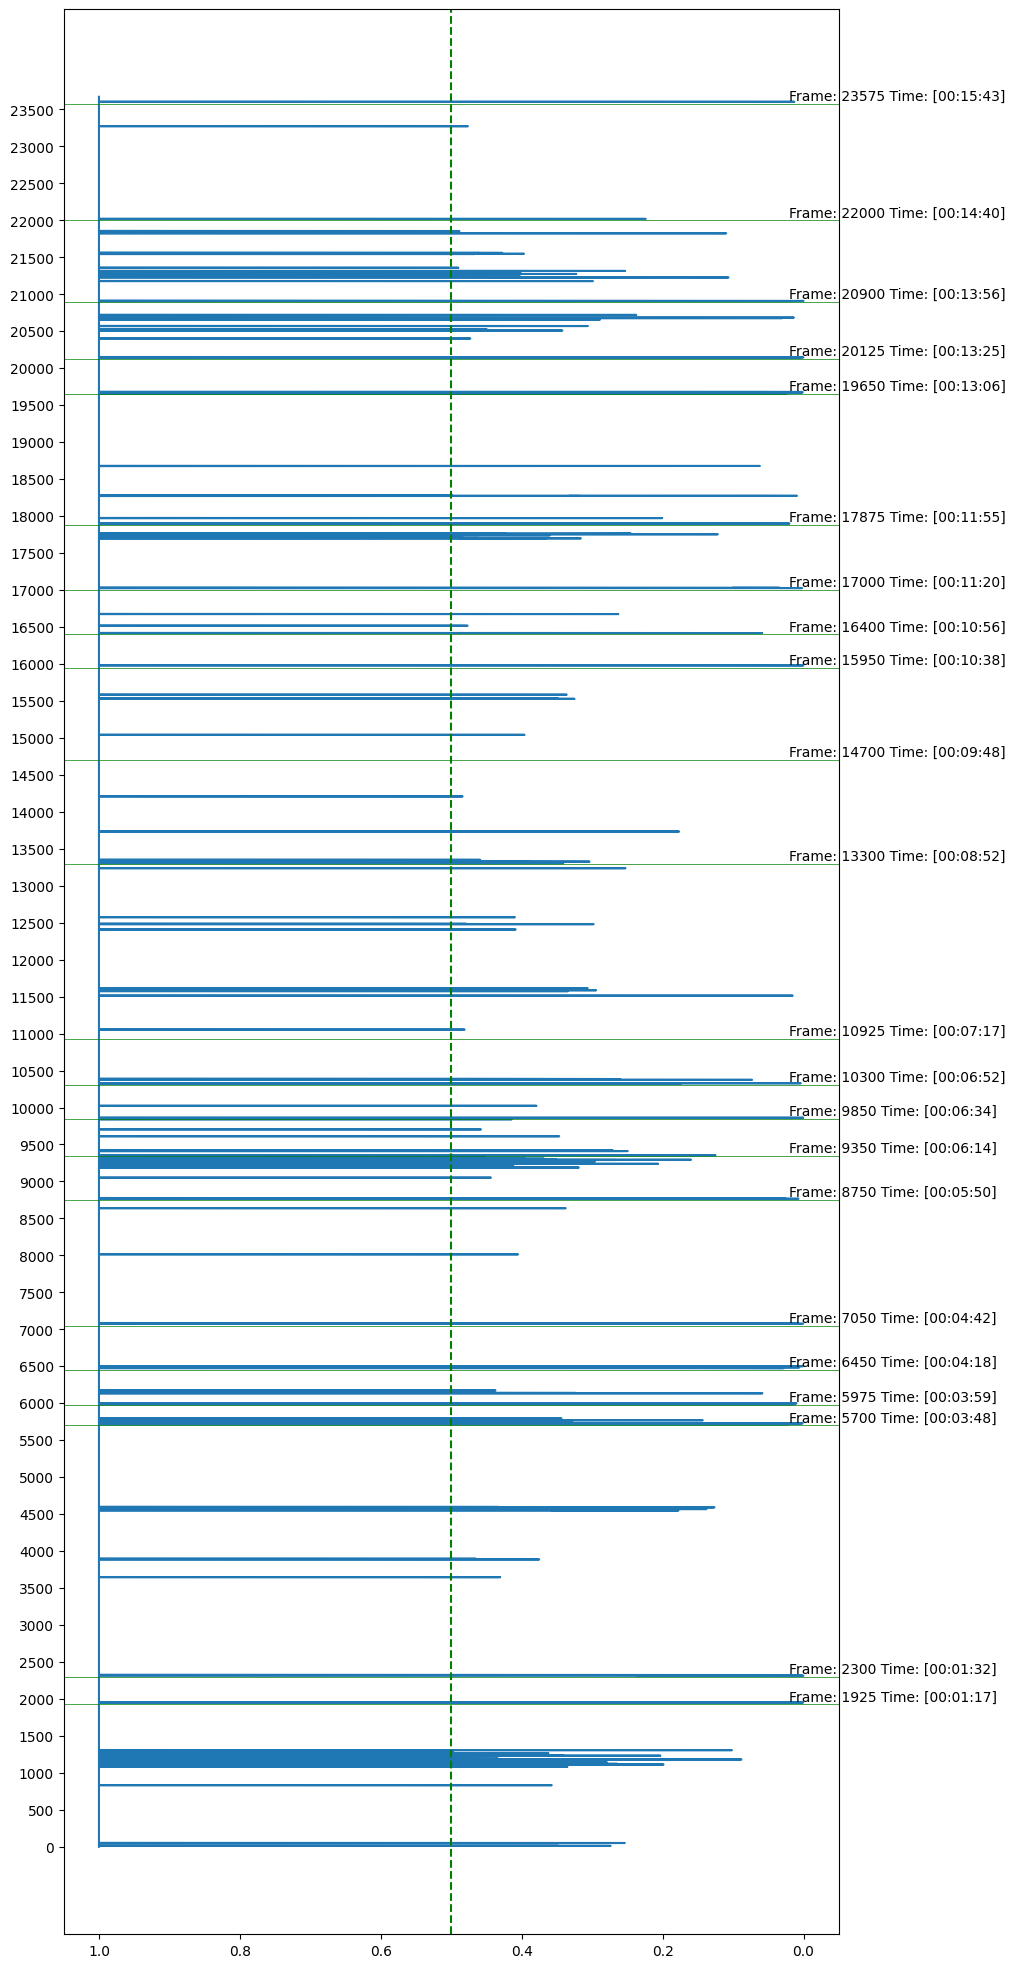

In [ ]:
plt.figure(figsize=(10,25))
plt.plot(frames_with_goal, range(len(frames_goal_conf)))
plt.gca().invert_xaxis() # Inverted axis because 1 - no goal and 0 - goal
plt.yticks(np.arange(0, len(frames_goal_conf), 500.0))
plt.axvline(x=0.5, color='green', linestyle='dashed')

for frame in actual_goal_frames:
  plt.axhline(y=frame, color='g', linewidth=0.5)
  plt.text(0.02, frame+50, f"Frame: {frame} Time: [{frame_to_hms(frame, fps)}]")

plt.show()

There are many coupled lines, let's find the minimums to decouple.

Basketball is a fast-paced game, we can tolerate a distance of 3 seconds.
In our case though, we can set it to 5 seconds because the actual goals are not super close to each other

In [ ]:
distance = int(fps*5) #
minimum_idx = find_minimums_idx(frames_goal_conf, 0.5, distance)
frames_with_goal_decoupled = [conf if idx in minimum_idx else 1 for idx, conf in enumerate(frames_goal_conf)]

In [ ]:
len(minimum_idx)

47

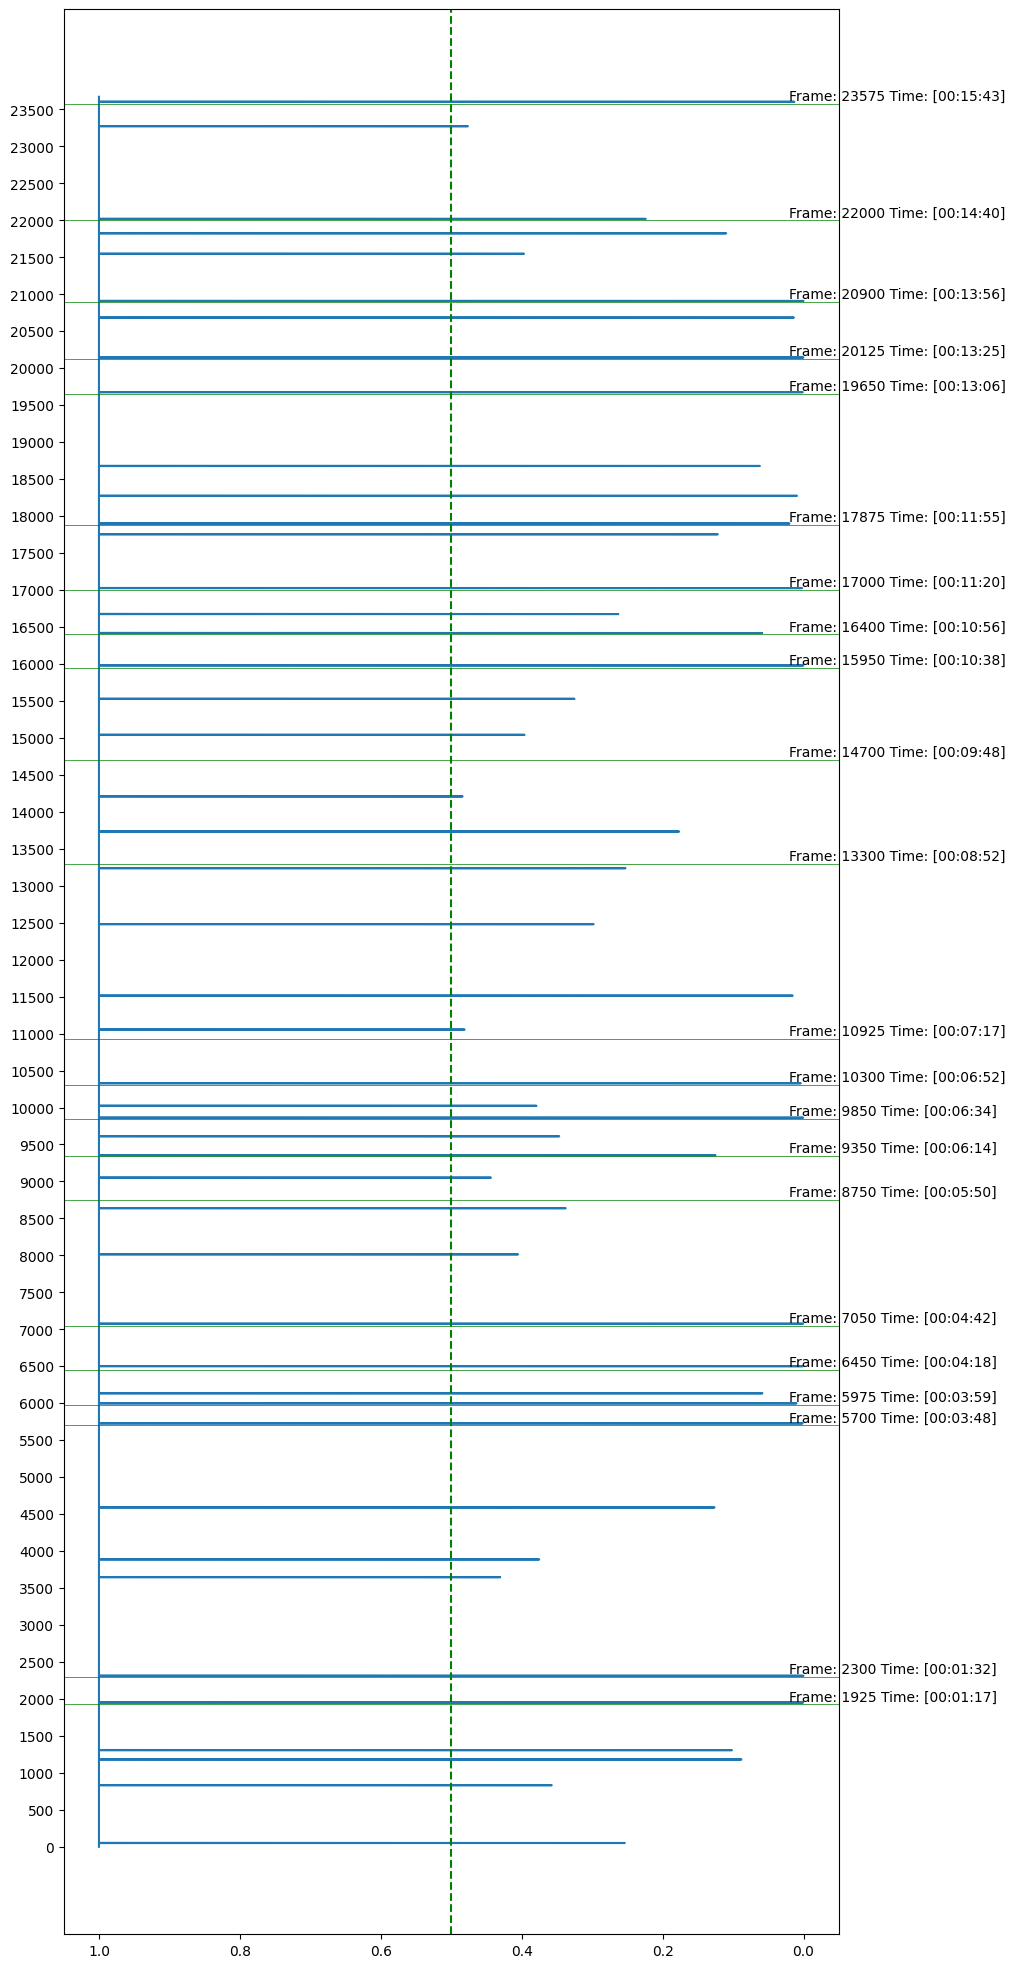

In [ ]:
plt.figure(figsize=(10,25))
plt.plot(frames_with_goal_decoupled, range(len(frames_with_goal_decoupled)))
plt.gca().invert_xaxis() # Inverted axis because 1 - no goal and 0 - goal
plt.yticks(np.arange(0, len(frames_with_goal_decoupled), 500.0))
plt.axvline(x=0.5, color='green', linestyle='dashed')

for frame in actual_goal_frames:
  plt.axhline(y=frame, color='g', linewidth=0.5)
  plt.text(0.02, frame+50, f"Frame: {frame} Time: [{frame_to_hms(frame, fps)}]")

plt.show()

Let's calculate [Presicion and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

For that we need [True Positive, False Negative, and False Positive](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#e273)

In [ ]:
goals_correct = 0
matched_indices = []

for agf in actual_goal_frames:
  for idx in minimum_idx:
    if idx - distance <= agf < idx + distance:
      goals_correct += 1
      matched_indices.append(agf)
      break

not_fount_goals = len(actual_goal_frames) - goals_correct
goals_incorrect = len(minimum_idx) - goals_correct

In [ ]:
print(f"True Positive: {goals_correct}")
print(f"False Negative: {not_fount_goals}")
print(f"False Positive: {goals_incorrect}")

True Positive: 20
False Negative: 2
False Positive: 27


In [ ]:
print(f"False Negative indices: {set(actual_goal_frames) - set(matched_indices)}")

False Negative indices: {14700, 10925}


In [ ]:
precision = goals_correct/len(minimum_idx)
recall = goals_correct/len(actual_goal_frames)

print(f"Proportion of positive identifications was actually correct: {precision}")
print(f"Proportion of actual positives was identified correctly:     {recall}")

Proportion of positive identifications was actually correct: 0.425531914893617
Proportion of actual positives was identified correctly:     0.9090909090909091


I studied the False Negative indices and cropped images that were made by the YOLOv5 detections and the problem not with classification but with the YOLOv5 itself, it had mistakes detecting a basket

In [ ]:
!wget -nv -O "false_basket_crops.zip" "https://ktureedu-my.sharepoint.com/:u:/g/personal/serhii_fedosov_nure_ua/ETHvOMH5d0ZOj87MbHOHkVMBu3dyaU0GCdikjgH-2kB3oA?e=EMrOqZ&download=1"
!unzip -qq "/content/false_basket_crops.zip"

2024-04-02 23:18:05 URL:https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/images/false_basket_crops.zip?ga=1 [1549941/1549941] -> "false_basket_crops.zip" [1]


In [ ]:
im1 = Image.open("/content/false_basket_crops/Screenshot 2024-04-03 020821.png")
im2 = Image.open("/content/false_basket_crops/Screenshot 2024-04-03 021002.png")

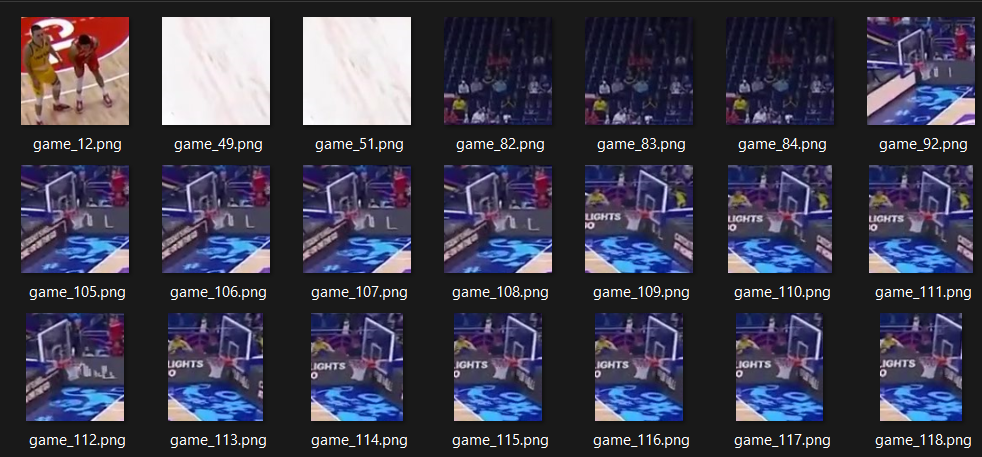

In [ ]:
im1

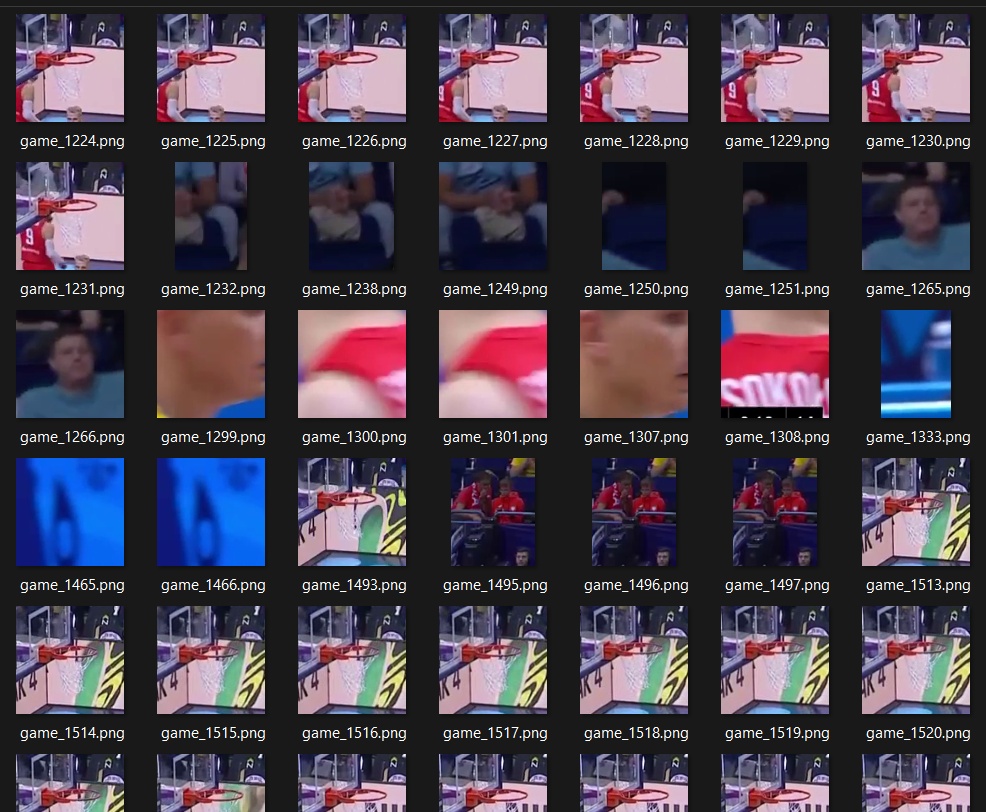

In [ ]:
im2

#### Save timings

In [ ]:
detected_goal_timings = [frame_to_hms(frame_idx, int(fps)) for frame_idx in minimum_idx]

with open('/content/detected_goal_timings.txt', 'w') as f:
  f.write(" ".join(detected_goal_timings))

#### Conclusions

Our model doesn't have the greatest performance, that we can see from this:

* Goals detected: 20
* Goals not detected: 2
* Not goals detected: 27

More than half of the detections are False Positive, which is a red flag.

The metrics we got are as follows: Precision: 0.425 and Recall: 0.91

Thus, the main problem was not the classification of goal/no goal, but the detection of the basket.

To conclude, our model has an **excellent recall**. It could be a useful tool to assist with the creation of basketball highlights. The model could suggest the timings, and we could choose to include them in the highlights or not.

Still, **half of the detections are mistaken**, it would be nice to invest some time into either using newer YOLO versions or being careful with data and dedicate some time for manual training data filtering and selection.  


## Highlights creation

In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

### Load video

In [ ]:
!wget -nv -O "basketball_game.mp4" "https://ktureedu-my.sharepoint.com/:v:/g/personal/serhii_fedosov_nure_ua/EZ4AqsTVlVhCpq4d5Fmj0v4B3bx7CS3HH-HTnMWgqxXcuQ?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=zchSRX&download=1"

video_path = "/content/basketball_game.mp4"

2024-04-03 15:31:24 URL:https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/videos/Ukraine%20v%20Poland%20FIBA%20EuroBasket%202022%20Q1.mp4?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&ga=1 [1380206922/1380206922] -> "basketball_game.mp4" [1]


### Load timings

In [ ]:
!wget -nv -O "detected_goal_timings.txt" "https://ktureedu-my.sharepoint.com/:t:/g/personal/serhii_fedosov_nure_ua/EUczWfGnjdRDtPinXc6TqX4B4rt9nPuCTifvX1yXR879iw?e=cc33Gt&download=1"

with open("/content/detected_goal_timings.txt") as f:
  line = f.readline()
  detected_goal_timings = line.split()

2024-04-03 15:31:25 URL:https://ktureedu-my.sharepoint.com/personal/serhii_fedosov_nure_ua/Documents/%d0%a5%d0%9d%d0%a3%d0%a0%d0%95/%d0%94%d0%b8%d0%bf%d0%bb%d0%be%d0%bc%d0%bd%d0%b0%20%d1%80%d0%be%d0%b1%d0%be%d1%82%d0%b0/detected_goal_timings.txt?ga=1 [422/422] -> "detected_goal_timings.txt" [1]


### Create clips

In [ ]:
def create_clips(video_file_path, timings: list[str], duration, save_dir=None):
    clips = []
    current_clip_start = None
    current_clip_end = None
    video = VideoFileClip(video_file_path)
    vide_length = video.duration

    timings = tuple(map(hms_to_seconds, timings))
    for timing in timings:
        clip_start = max(0, timing - duration / 2)
        clip_end = min(timing + duration / 2, vide_length)

        if current_clip_end is None or clip_start > current_clip_end:
            # If there's no overlap or this is the first clip
            if current_clip_start is not None:
              print(f"Making a clip of from {current_clip_start} to {current_clip_end}")
              clip = video.subclip(current_clip_start, current_clip_end)
              clips.append(clip)
              if save_dir:
                clip_filename = os.path.join(save_dir, f"({current_clip_start}_{current_clip_end}).mp4")
                clip.write_videofile(clip_filename)
            current_clip_start = clip_start
            current_clip_end = clip_end
        else:
            # There's an overlap, extend the current clip
            current_clip_end = max(current_clip_end, clip_end)

    # Add the last clip
    if current_clip_start is not None:
        print(f"Making a clip of from {current_clip_start} to {current_clip_end}")
        clip = video.subclip(current_clip_start, current_clip_end)
        clips.append(clip)
        if save_dir:
          clip_filename = os.path.join(save_dir, f"({current_clip_start}_{current_clip_end}).mp4")
          clip.write_videofile(clip_filename)

    return clips

def save_clip(clip, save_dir, start_time, end_time):
    clip_filename = os.path.join(save_dir, f"({start_time}_{end_time}).mp4")
    clip.write_videofile(clip_filename)

In [ ]:
os.makedirs("/content/clips", exist_ok=True)
clips_dir = "/content/clips"
clips = create_clips(video_path, detected_goal_timings, 10, clips_dir)



chunk: 100%|█████████▉| 9769/9813 [05:56<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [05:56<00:00, 711.90it/s, now=None]

Making a clip of from 0 to 7.0
Moviepy - Building video /content/clips/(0_7.0).mp4.
MoviePy - Writing audio in (0_7.0)TEMP_MPY_wvf_snd.mp3




chunk: 100%|█████████▉| 9769/9813 [05:57<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [05:57<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(0_7.0).mp4





chunk: 100%|█████████▉| 9769/9813 [06:19<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [06:19<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(0_7.0).mp4
Making a clip of from 28.0 to 38.0




chunk: 100%|█████████▉| 9769/9813 [06:19<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [06:19<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(28.0_38.0).mp4.
MoviePy - Writing audio in (28.0_38.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [06:20<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [06:20<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(28.0_38.0).mp4





chunk: 100%|█████████▉| 9769/9813 [06:43<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [06:43<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(28.0_38.0).mp4
Making a clip of from 42.0 to 57.0




chunk: 100%|█████████▉| 9769/9813 [06:43<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [06:43<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(42.0_57.0).mp4.
MoviePy - Writing audio in (42.0_57.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [06:44<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [06:44<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(42.0_57.0).mp4





chunk: 100%|█████████▉| 9769/9813 [07:18<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [07:18<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(42.0_57.0).mp4
Making a clip of from 73.0 to 83.0




chunk: 100%|█████████▉| 9769/9813 [07:19<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [07:19<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(73.0_83.0).mp4.
MoviePy - Writing audio in (73.0_83.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [07:19<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [07:19<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(73.0_83.0).mp4





chunk: 100%|█████████▉| 9769/9813 [07:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [07:40<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(73.0_83.0).mp4
Making a clip of from 87.0 to 97.0




chunk: 100%|█████████▉| 9769/9813 [07:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [07:40<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(87.0_97.0).mp4.
MoviePy - Writing audio in (87.0_97.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [07:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [07:40<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(87.0_97.0).mp4





chunk: 100%|█████████▉| 9769/9813 [08:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [08:05<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(87.0_97.0).mp4
Making a clip of from 140.0 to 160.0




chunk: 100%|█████████▉| 9769/9813 [08:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [08:05<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(140.0_160.0).mp4.
MoviePy - Writing audio in (140.0_160.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [08:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [08:05<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(140.0_160.0).mp4





chunk: 100%|█████████▉| 9769/9813 [08:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [08:47<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(140.0_160.0).mp4
Making a clip of from 178.0 to 188.0




chunk: 100%|█████████▉| 9769/9813 [08:48<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [08:48<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(178.0_188.0).mp4.
MoviePy - Writing audio in (178.0_188.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [08:48<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [08:48<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(178.0_188.0).mp4





chunk: 100%|█████████▉| 9769/9813 [09:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [09:05<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(178.0_188.0).mp4
Making a clip of from 224.0 to 250.0




chunk: 100%|█████████▉| 9769/9813 [09:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [09:05<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(224.0_250.0).mp4.
MoviePy - Writing audio in (224.0_250.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [09:06<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [09:06<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(224.0_250.0).mp4





chunk: 100%|█████████▉| 9769/9813 [10:09<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:09<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(224.0_250.0).mp4
Making a clip of from 255.0 to 265.0




chunk: 100%|█████████▉| 9769/9813 [10:09<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:10<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(255.0_265.0).mp4.
MoviePy - Writing audio in (255.0_265.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [10:10<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:10<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(255.0_265.0).mp4





chunk: 100%|█████████▉| 9769/9813 [10:33<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:33<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(255.0_265.0).mp4
Making a clip of from 278.0 to 288.0




chunk: 100%|█████████▉| 9769/9813 [10:33<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:33<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(278.0_288.0).mp4.
MoviePy - Writing audio in (278.0_288.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [10:33<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:33<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(278.0_288.0).mp4





chunk: 100%|█████████▉| 9769/9813 [10:59<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:59<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(278.0_288.0).mp4
Making a clip of from 315.0 to 325.0




chunk: 100%|█████████▉| 9769/9813 [10:59<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [10:59<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(315.0_325.0).mp4.
MoviePy - Writing audio in (315.0_325.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [11:00<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:00<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(315.0_325.0).mp4





chunk: 100%|█████████▉| 9769/9813 [11:24<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:24<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(315.0_325.0).mp4
Making a clip of from 340.0 to 350.0




chunk: 100%|█████████▉| 9769/9813 [11:24<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:24<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(340.0_350.0).mp4.
MoviePy - Writing audio in (340.0_350.0)TEMP_MPY_wvf_snd.mp3




chunk: 100%|█████████▉| 9769/9813 [11:25<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:25<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(340.0_350.0).mp4





chunk: 100%|█████████▉| 9769/9813 [11:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:47<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(340.0_350.0).mp4
Making a clip of from 357.0 to 367.0




chunk: 100%|█████████▉| 9769/9813 [11:48<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:48<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(357.0_367.0).mp4.
MoviePy - Writing audio in (357.0_367.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [11:48<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [11:48<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(357.0_367.0).mp4





chunk: 100%|█████████▉| 9769/9813 [12:12<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [12:12<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(357.0_367.0).mp4
Making a clip of from 369.0 to 405.0




chunk: 100%|█████████▉| 9769/9813 [12:12<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [12:12<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(369.0_405.0).mp4.
MoviePy - Writing audio in (369.0_405.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [12:13<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [12:13<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(369.0_405.0).mp4





chunk: 100%|█████████▉| 9769/9813 [13:39<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [13:39<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(369.0_405.0).mp4
Making a clip of from 408.0 to 418.0




chunk: 100%|█████████▉| 9769/9813 [13:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [13:40<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(408.0_418.0).mp4.
MoviePy - Writing audio in (408.0_418.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [13:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [13:40<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(408.0_418.0).mp4





chunk: 100%|█████████▉| 9769/9813 [14:03<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:03<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(408.0_418.0).mp4
Making a clip of from 437.0 to 447.0




chunk: 100%|█████████▉| 9769/9813 [14:04<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:04<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(437.0_447.0).mp4.
MoviePy - Writing audio in (437.0_447.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [14:04<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:04<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(437.0_447.0).mp4





chunk: 100%|█████████▉| 9769/9813 [14:27<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:27<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(437.0_447.0).mp4
Making a clip of from 455.0 to 465.0




chunk: 100%|█████████▉| 9769/9813 [14:27<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:27<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(455.0_465.0).mp4.
MoviePy - Writing audio in (455.0_465.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [14:27<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:27<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(455.0_465.0).mp4





chunk: 100%|█████████▉| 9769/9813 [14:52<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:52<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(455.0_465.0).mp4
Making a clip of from 494.0 to 504.0




chunk: 100%|█████████▉| 9769/9813 [14:52<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:52<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(494.0_504.0).mp4.
MoviePy - Writing audio in (494.0_504.0)TEMP_MPY_wvf_snd.mp3




chunk: 100%|█████████▉| 9769/9813 [14:53<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [14:53<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(494.0_504.0).mp4





chunk: 100%|█████████▉| 9769/9813 [15:16<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [15:16<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(494.0_504.0).mp4
Making a clip of from 524.0 to 534.0




chunk: 100%|█████████▉| 9769/9813 [15:17<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [15:17<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(524.0_534.0).mp4.
MoviePy - Writing audio in (524.0_534.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [15:17<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [15:17<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(524.0_534.0).mp4





chunk: 100%|█████████▉| 9769/9813 [15:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [15:40<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(524.0_534.0).mp4
Making a clip of from 544.0 to 554.0




chunk: 100%|█████████▉| 9769/9813 [15:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [15:40<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(544.0_554.0).mp4.
MoviePy - Writing audio in (544.0_554.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [15:41<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [15:41<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(544.0_554.0).mp4





chunk: 100%|█████████▉| 9769/9813 [16:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:05<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(544.0_554.0).mp4
Making a clip of from 563.0 to 573.0




chunk: 100%|█████████▉| 9769/9813 [16:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:05<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(563.0_573.0).mp4.
MoviePy - Writing audio in (563.0_573.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [16:05<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:05<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(563.0_573.0).mp4





chunk: 100%|█████████▉| 9769/9813 [16:29<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:29<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(563.0_573.0).mp4
Making a clip of from 596.0 to 606.0




chunk: 100%|█████████▉| 9769/9813 [16:30<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:30<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(596.0_606.0).mp4.
MoviePy - Writing audio in (596.0_606.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [16:30<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:30<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(596.0_606.0).mp4





chunk: 100%|█████████▉| 9769/9813 [16:53<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:53<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(596.0_606.0).mp4
Making a clip of from 616.0 to 626.0




chunk: 100%|█████████▉| 9769/9813 [16:54<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:54<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(616.0_626.0).mp4.
MoviePy - Writing audio in (616.0_626.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [16:54<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [16:54<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(616.0_626.0).mp4





chunk: 100%|█████████▉| 9769/9813 [17:19<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [17:19<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(616.0_626.0).mp4
Making a clip of from 634.0 to 644.0




chunk: 100%|█████████▉| 9769/9813 [17:20<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [17:20<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(634.0_644.0).mp4.
MoviePy - Writing audio in (634.0_644.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [17:20<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [17:20<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(634.0_644.0).mp4





chunk: 100%|█████████▉| 9769/9813 [17:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [17:40<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(634.0_644.0).mp4
Making a clip of from 651.0 to 661.0




chunk: 100%|█████████▉| 9769/9813 [17:40<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [17:40<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(651.0_661.0).mp4.
MoviePy - Writing audio in (651.0_661.0)TEMP_MPY_wvf_snd.mp3




chunk: 100%|█████████▉| 9769/9813 [17:41<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [17:41<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(651.0_661.0).mp4





chunk: 100%|█████████▉| 9769/9813 [18:01<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:01<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(651.0_661.0).mp4
Making a clip of from 662.0 to 672.0




chunk: 100%|█████████▉| 9769/9813 [18:01<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:01<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(662.0_672.0).mp4.
MoviePy - Writing audio in (662.0_672.0)TEMP_MPY_wvf_snd.mp3


                                                                    

chunk: 100%|█████████▉| 9769/9813 [18:01<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:01<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(662.0_672.0).mp4





chunk: 100%|█████████▉| 9769/9813 [18:22<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:22<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(662.0_672.0).mp4
Making a clip of from 676.0 to 686.0




chunk: 100%|█████████▉| 9769/9813 [18:22<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:22<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(676.0_686.0).mp4.
MoviePy - Writing audio in (676.0_686.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [18:22<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:22<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(676.0_686.0).mp4





chunk: 100%|█████████▉| 9769/9813 [18:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:47<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(676.0_686.0).mp4
Making a clip of from 705.0 to 720.0




chunk: 100%|█████████▉| 9769/9813 [18:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:47<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(705.0_720.0).mp4.
MoviePy - Writing audio in (705.0_720.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [18:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [18:47<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(705.0_720.0).mp4





chunk: 100%|█████████▉| 9769/9813 [19:23<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [19:23<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(705.0_720.0).mp4
Making a clip of from 725.0 to 735.0




chunk: 100%|█████████▉| 9769/9813 [19:24<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [19:24<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(725.0_735.0).mp4.
MoviePy - Writing audio in (725.0_735.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [19:24<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [19:24<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(725.0_735.0).mp4





chunk: 100%|█████████▉| 9769/9813 [19:46<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [19:46<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(725.0_735.0).mp4
Making a clip of from 742.0 to 752.0




chunk: 100%|█████████▉| 9769/9813 [19:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [19:47<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(742.0_752.0).mp4.
MoviePy - Writing audio in (742.0_752.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [19:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [19:47<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(742.0_752.0).mp4





chunk: 100%|█████████▉| 9769/9813 [20:11<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:11<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(742.0_752.0).mp4
Making a clip of from 782.0 to 792.0




chunk: 100%|█████████▉| 9769/9813 [20:12<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:12<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(782.0_792.0).mp4.
MoviePy - Writing audio in (782.0_792.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [20:12<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:12<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(782.0_792.0).mp4





chunk: 100%|█████████▉| 9769/9813 [20:36<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:36<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(782.0_792.0).mp4
Making a clip of from 800.0 to 810.0




chunk: 100%|█████████▉| 9769/9813 [20:37<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:37<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(800.0_810.0).mp4.
MoviePy - Writing audio in (800.0_810.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [20:37<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:37<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(800.0_810.0).mp4





chunk: 100%|█████████▉| 9769/9813 [20:59<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [20:59<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(800.0_810.0).mp4
Making a clip of from 822.0 to 841.0




chunk: 100%|█████████▉| 9769/9813 [21:00<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [21:00<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(822.0_841.0).mp4.
MoviePy - Writing audio in (822.0_841.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [21:00<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [21:00<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(822.0_841.0).mp4





chunk: 100%|█████████▉| 9769/9813 [21:46<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [21:46<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(822.0_841.0).mp4
Making a clip of from 856.0 to 866.0




chunk: 100%|█████████▉| 9769/9813 [21:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [21:47<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(856.0_866.0).mp4.
MoviePy - Writing audio in (856.0_866.0)TEMP_MPY_wvf_snd.mp3




chunk: 100%|█████████▉| 9769/9813 [21:47<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [21:47<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(856.0_866.0).mp4





chunk: 100%|█████████▉| 9769/9813 [22:09<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [22:09<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(856.0_866.0).mp4
Making a clip of from 868.0 to 885.0




chunk: 100%|█████████▉| 9769/9813 [22:10<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [22:10<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(868.0_885.0).mp4.
MoviePy - Writing audio in (868.0_885.0)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [22:10<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [22:10<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(868.0_885.0).mp4





chunk: 100%|█████████▉| 9769/9813 [22:51<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [22:51<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(868.0_885.0).mp4
Making a clip of from 925.0 to 935.0




chunk: 100%|█████████▉| 9769/9813 [22:51<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [22:51<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(925.0_935.0).mp4.
MoviePy - Writing audio in (925.0_935.0)TEMP_MPY_wvf_snd.mp3




chunk: 100%|█████████▉| 9769/9813 [22:52<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [22:52<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(925.0_935.0).mp4





chunk: 100%|█████████▉| 9769/9813 [23:14<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [23:14<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(925.0_935.0).mp4
Making a clip of from 939.0 to 946.92




chunk: 100%|█████████▉| 9769/9813 [23:15<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [23:15<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/clips/(939.0_946.92).mp4.
MoviePy - Writing audio in (939.0_946.92)TEMP_MPY_wvf_snd.mp3


                                                                   

chunk: 100%|█████████▉| 9769/9813 [23:15<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [23:15<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/clips/(939.0_946.92).mp4





chunk: 100%|█████████▉| 9769/9813 [23:33<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [23:33<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/clips/(939.0_946.92).mp4


In [ ]:
!zip -r "clips.zip" "/content/clips"

In [ ]:
def concatenate_clips(clips, output_path):
    final_clip = concatenate_videoclips(clips)
    final_clip.write_videofile(output_path)

In [ ]:
all_highlights_video_path = "/content/highlights.mp4"
final_highlight_clip = concatenate_clips(clips, all_highlights_video_path )



chunk: 100%|█████████▉| 9769/9813 [23:33<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [23:33<00:00, 711.90it/s, now=None]

Moviepy - Building video /content/highlights.mp4.
MoviePy - Writing audio in highlightsTEMP_MPY_wvf_snd.mp3


                                                                     

chunk: 100%|█████████▉| 9769/9813 [23:48<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [23:48<00:00, 711.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /content/highlights.mp4





chunk: 100%|█████████▉| 9769/9813 [41:15<00:00, 711.90it/s, now=None]

chunk: 100%|█████████▉| 9769/9813 [41:15<00:00, 711.90it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/highlights.mp4
